# PySpice_EyePoint_CurveTracer
## часть проекта по восстановлению электронной схемы характериографом

## https://github.com/vasily84/PySpice_CurveTracer 


### Необходимы - python3.x, sklearn,PySpice

### необходимые библиотеки -
### PySpice - симуляция электронных схем из Python
https://pyspice.fabrice-salvaire.fr/ 

https://github.com/FabriceSalvaire/PySpice

### scikit-learn библиотека машинного обучения
https://scikit-learn.org/stable/index.html

## Как использовать?
### Необходимо задать рабочую папку программы в переменной FILEBASE_ROOT ( ячейка ниже). 
### Варианты запуска программы :

* Первый запуск - Папка задана, но не существует: программа создаст папку и скачает библиотеку spice компонентов из github, затем сгенерирует синтетические данные для схем, описанных в коде и построит модели машинного обучения для них. Для каждой модели создается отдельная папка внутри FILEBASE_ROOT. Туда же пишется её .pickle образ. При последующих запусках модели будут подгружаться с диска.


* Второй и прочие запуски - (папка FILEBASE_ROOT содержит библиотеку spice компонентов и дополнительные папки с обученными моделями) обученные модели загружаются с диска.


* При необходимости переобучить модель - можно удалить файл модели .pickle из ее подпапки или всю её подпапку - при следующем запуске ноутбука модель будет перетренирована.


* При необходимости перенести ноутбук целиком на другой компьютер можно скопировать папку FILEBASE_ROOT и указать правильные пути к ней, но следует помнить о возможной несовместимости .pickle объектов для разных версий питона и библиотек.

### Код написан последовательно сверху вниз-
### для тестирования и исследовательских целей удобнее всего запускать ноутбук целиком Menu->Kernel->Restart & Run All, помещая необходимый дополнительный код в самые нижние ячейки ноутбука, и затем дописывая и запуская ячейки


In [1]:
FILEBASE_ROOT = 'E:\EyePoint' # путь к рабочей папке программы

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
from sklearn import __version__ as sk_version
from scipy.signal import resample

import PySpice
import PySpice.Logging.Logging as Logging
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Unit import *

import os
import uuid
import random
import requests
import zipfile
import json

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10,8)

logger = Logging.setup_logging()
PySpice.show_version()

print('sklearn version '+sk_version)

Circuit_Set = set() # set of all availible curcuits 

PySpice Version 1.4.3
sklearn version 1.0.2


### проверяем пути к рабочей папке, при необходимости подгружаем spice библиотеки компонентов и обученные модели с github

In [3]:
def download_and_unzip(filePath):
    print('downloading started..')
                       
    url = 'https://github.com/vasily84/PySpice_CurveTracer/raw/main/spice_library.zip'
    # Downloading the file by sending the request to the URL
    req = requests.get(url)

    zipName = os.path.join(filePath,'temp.zip')
    print('from '+str(url)+'\ndownloaded '+str(len(req.content))+' bytes')
    
    # Writing the file to the local file system
    with open(zipName,'wb') as output_file:
        output_file.write(req.content)
    print('downloading completed, UnZip started..')
    
    # unzip 
    with zipfile.ZipFile(zipName, 'r') as zip_ref:
        zip_ref.extractall(filePath)
        
    os.remove(zipName)
    print('UnZip completed..')
    
    
# проверяем пути к рабочей папке,
# при необходимости подгружаем spice библиотеки компонентов
# и обученные модели с github
if not os.path.exists(FILEBASE_ROOT):
    os.makedirs(FILEBASE_ROOT)
    download_and_unzip(FILEBASE_ROOT)

print('\nsimulation dataset on:\n'+FILEBASE_ROOT)

libraries_path = os.path.join(FILEBASE_ROOT,'spice_library')
print('\nspice models library on:\n'+libraries_path)
spice_library = SpiceLibrary(libraries_path)
print(spice_library['1N4148'])


simulation dataset on:
E:\EyePoint

spice models library on:
E:\EyePoint\spice_library
E:\EyePoint\spice_library\diode\switching\1N4148.lib


### код CreateCVC базируется на библиотеке MySpice
https://github.com/LukyanovM/MySpice

используем эту библиотеку, ибо она максимально близко имитирует прибор
EyePoint https://eyepoint.physlab.ru/ru/

In [4]:
class CurveTracer_Settings():
    """ EyePoint hardware settings struct"""
    def __init__(self,F=100,V=5.,Rcs=4750.,SNR=70.0,lendata=100,cycle=3,json=None):
        self.F = F
        self.V = V
        self.Rcs = Rcs
        self.SNR = SNR
        self.lendata = lendata
        self.cycle = cycle
        if json is not None:
            self.from_json(json)
    
    def to_numpy(self):
        arr = np.array([self.F, self.V, self.Rcs, self.SNR, self.lendata, self.cycle])
        return arr
    
    def from_numpy(self,arr):
        self.F = arr[0]
        self.V = arr[1]
        self.Rcs = arr[2]
        self.SNR = arr[3]
        self.lendata = int(arr[4])
        self.cycle = int(arr[5])
        return self
        
    def __str__(self):
        s = 'F='+str(self.F)+' V='+str(self.V)+' lendata='+str(self.lendata)+' Rcs='+str(self.Rcs)+' cycle='+str(self.cycle)+' SNR='+str(self.SNR)
        return s
    
    def __eq__(self,obj):
        """ сравниваем по критерию - частота, напряжение, число точек,вн.сопротивление """
        lendata_ok = (self.lendata==obj.lendata)
        F_ok = abs(self.F-obj.F) <= 0.1 # точность сравнения 0.1 Гц
        V_ok = abs(self.V-obj.V) <= 0.1 # точность сравнения 0.1 Вольт
        Rcs_ok = abs(self.Rcs-obj.Rcs) <=0.1 # точность 0.1 Ом
        return (lendata_ok and F_ok and V_ok)
    
    def __hash__(self):
        """ поддержка hash для работы с множествами"""
        return hash((self.F,self.V,self.lendata,self.Rcs))
    
    def from_json(self,jsonRec):
        #print(jsonRec['iv_curves'][0]['measurement_settings'])
        self.F = jsonRec['iv_curves'][0]['measurement_settings']['probe_signal_frequency']
        self.V = jsonRec['iv_curves'][0]['measurement_settings']['max_voltage']
        self.Rcs = jsonRec['iv_curves'][0]['measurement_settings']['internal_resistance']
        sr = jsonRec['iv_curves'][0]['measurement_settings']['sampling_rate']
        self.lendata = sr//self.F
        return self
        

def CreateCVC(circuit,ct):
    """ просимулировать схему в PySpice. circuit - схема, ct - настройки симуляции"""
    cycle = ct.cycle
    lendata = ct.lendata
    period = 1 / ct.F
    rms_voltage = ct.V / np.sqrt(2)
    # добавляем испытательный щуп в схему
    circuit.R('cs', 'input', 'input_dummy', ct.Rcs)
    circuit.AcLine('Current', circuit.gnd, 'input_dummy', rms_voltage=rms_voltage, frequency=ct.F)
    
    simulator = circuit.simulator()
    analysis = simulator.transient(step_time=period / lendata, end_time=period * cycle)
    analysis.input_dummy = analysis.input_dummy[len(analysis.input_dummy)-lendata:len(analysis.input_dummy)]
    analysis.VCurrent = analysis.VCurrent[len(analysis.VCurrent)-lendata:len(analysis.VCurrent)]
# Расчитываем шум независмо для тока и напряжения исходя из среднеквадратичных значений и одинакового SNR
    avg_V_db = 10 * np.log10(np.mean(np.array(analysis.input_dummy, dtype=float) ** 2))
    avg_Vnoise_db = avg_V_db - ct.SNR
    Vnoise = np.random.normal(0, np.sqrt(10 ** (avg_Vnoise_db / 10)), len(analysis.input_dummy))
    analysis.input_dummy = np.array(analysis.input_dummy, dtype=float) + Vnoise
    avg_I_db = 10 * np.log10(np.mean(np.array(analysis.VCurrent, dtype=float) ** 2))
    avg_Inoise_db = avg_I_db - ct.SNR
    Inoise = np.random.normal(0, np.sqrt(10 ** (avg_Inoise_db / 10)), len(analysis.VCurrent))
    analysis.VCurrent = np.array(analysis.VCurrent, dtype=float) + Inoise
    # удаляем испытательный щуп из схемы
    circuit.Rcs.detach()
    circuit.VCurrent.detach()
    return analysis

class CAnalysis():
    def __init__(self,VCurrent=None,input_dummy=None,json=None):
        self.VCurrent = VCurrent
        self.input_dummy = input_dummy
        if json is not None:
            self.from_json(json)
    
    def from_json(self,jsonRec):
        self.VCurrent = jsonRec["iv_curves"][0]["currents"]
        self.input_dummy = jsonRec["iv_curves"][0]["voltages"]
        return self
        
def load_JSON_Records(filePath):
    """ загрузка с диска набора снятых прибором данных - самого сигнала и параметров его съемки """
    with open(filePath, "r") as jfile:
        J = json.load(jfile)
    return J["elements"][0]["pins"]

def plot_analysis_IV(analysis,label='',ax=None):
    """ plot I(V) curve for analysis """
    if ax is None:
        plt.plot(analysis.input_dummy, analysis.VCurrent,label=label)
        plt.title('I(V)')
        plt.xlabel('Напряжение [В]')
        plt.ylabel('Сила тока [А]')
        return
    ax.plot(analysis.input_dummy, analysis.VCurrent,label=label)
    ax.set_title('I(V)')
    ax.set_xlabel('Напряжение [В]')
    ax.set_ylabel('Сила тока [А]')
    

Cоставим множество из доступных варианов режимов работы прибора

In [5]:
# варианты настройки пробора по умолчанию - перечисляем врукопашную 
ct_List = list()
ct = CurveTracer_Settings(F=1.,V=3.3,lendata=100,Rcs=475.)
ct_List.append(ct)
ct = CurveTracer_Settings(F=100.,V=5.,lendata=100,Rcs=4750.)
ct_List.append(ct)
ct = CurveTracer_Settings(F=100_000,V=12.,lendata=20,Rcs=47500.)
ct_List.append(ct)

try: # просканируем папку, добавим оттуда варианты настройки прибора
    path_json = os.path.join(FILEBASE_ROOT,'RealSignalFolder')
    fileList = [f for f in os.listdir(path_json) if f.endswith('.json')]
    
    # просмотрим доступные файлы, составим множество из конфигураций прибора
    for f1 in fileList:
        ff = os.path.join(FILEBASE_ROOT,'RealSignalFolder',f1)
        jRecs = load_JSON_Records(ff)
        for j in jRecs:
            ct = CurveTracer_Settings(json=j)
            #analysis = CAnalysis(json=j)
            ct_List.append(ct)
finally:
    # удалим дубликаты
    ct_List_uniq = []
    for ct in ct_List:
        if ct not in ct_List_uniq:
            ct_List_uniq.append(ct)
    ct_List = ct_List_uniq
    print('**list of curve tracer settings:')
    for ct in ct_List:
         print(ct)


**list of curve tracer settings:
F=1.0 V=3.3 lendata=100 Rcs=475.0 cycle=3 SNR=70.0
F=100.0 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0
F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


#### пример использования CreateCVC

In [6]:
%%script false
circuit = Circuit('RD')
circuit.include(spice_library['1N4148'])
circuit.R(1,'input',1,10@u_kOhm)
circuit.X('D1', '1N4148', 1, circuit.gnd)
circuit.R(2,'input',circuit.gnd,20@u_kOhm)

analysis = CreateCVC(circuit,CurveTracer_Settings())
        
plt.plot(analysis.input_dummy, analysis.VCurrent)
plt.xlabel('Напряжение [В]')
plt.ylabel('Сила тока [А]')
plt.show()

Couldn't find program: 'false'


### как построена база?
каждой схеме соответствует папка, в которой хранятся файлы массивов симуляции c номиналами схемы и параметрами прибора,и circuit файл - информация о самой схеме

In [7]:
def save_cir_analysis(fileName,circuit_params,curve_params,analysis):
    """ save circuit nominals,curve tracer parameters, voltage and current arrays to file"""
    with open(fileName, 'wb') as f:
        np.save(f,circuit_params)
        np.save(f,curve_params)
        np.save(f,analysis.VCurrent)
        np.save(f,analysis.input_dummy)
    
def make_sure_path(path_title):
    """ create path if path not exist, return full path """
    dirName = os.path.join(FILEBASE_ROOT,path_title)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
    return dirName

def save_circuit(dirName,circuit):
    """ save sample circuit on disk """
    fileName = os.path.join(dirName,circuit.title+'.cir')
    with open(fileName,'w') as f:
        f.write(str(circuit))
        

In [8]:
def load_circuit_dataset(path_dataset,ct=None,shuffle=True,max_files=None):
    """ load dataset from circuit folder.
    return X,y """
    fileList = [f for f in os.listdir(path_dataset) if f.endswith('.npy')]
    
    if shuffle: 
        random.shuffle(fileList)
        
    if not max_files is None:
        max_files = min(max_files,len(fileList))
        fileList=fileList[0:max_files]
    
    X_data,y_data=[],[]
    
    for fileName in tqdm(fileList): # process files
        with open(os.path.join(path_dataset,fileName), 'rb') as f:
            circuit_params = np.load(f)
            curve_params = np.load(f)
            VCurrent = np.load(f)
            input_dummy = np.load(f)  
                                
            if not ct is None: 
                ct0 = CurveTracer_Settings().from_numpy(curve_params)
                if not (ct0==ct):
                    continue # пропускаем сигналы с неподходящими параметрами
                    
        # append data to arrays
        y_data.append(circuit_params)
        X_data.append([VCurrent,input_dummy])
        
    return np.array(X_data),np.array(y_data)

## препроцессор данных для моделей -
### делает преобразование фурье, прореживание и прочие манипуляции со входными сигналами

#### Мотивация к добавлению в признаковое пространство конкретных алгебраических величин (закон Ома):

Ток $I=V/R$

Сопротивление $R=V/I$

Проводимость $\sigma=1/R=I/V$

Напряжение на конденсаторе $V=C*Q$

Заряд конденсатора $Q=\int Idt \sim \sum {I}$ 

Емкость конденсатора $C=V/Q$ или $C \sim V/\sum {I}$

Диф. сопротивление $R_d= \frac {\Delta {V}} {\Delta{I}}$

Диф. Проводимость $\sigma_d=1/R_d=\Delta {I}/\Delta {V}$

Напряжение на индуктивности $ V = -L \frac {\Delta{I}} {\Delta{t}} \sim L\Delta{I}$

Величина индуктивности $L \sim \frac {V} {\Delta{I}}$

##### Итого - параметры R, C, L линейно связаны с сигналами V, I, их производными (изменениями от точке к точке) и интегралами (суммами)


#### Мотивация к использованию логарифмов:

$\log {(AB)} = \log {A}+\log {B} $

$\log {\frac {A} {B}} = \log {A}-\log{B}$

##### Итого - можно взять логарифмы от исходных сигналов, их производных и интегралов, и линейная модель их свяжет с логарифмами искомых параметров R, C, L. 

In [9]:
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from scipy.fft import rfft

def my_xgb_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        I_fft = I_fft[:20] # use only first 20 points on freq domain
        I_abs = np.abs(I_fft)
        I_angle = np.angle(I_fft)
        I_real = np.real(I_fft)
        I_imag = np.imag(I_fft)
        
        V_fft = rfft(V_signal)
        V_fft = V_fft[:20] # use only first 20 points on freq domain
        V_abs = np.abs(V_fft)
        V_angle = np.angle(V_fft)
        V_real = np.real(V_fft)
        V_imag = np.imag(V_fft)

        x1 = np.hstack((x,I_abs,I_angle,I_real,I_imag,V_abs,V_angle,V_real,V_imag))
        Xa.append(x1)
        
    return np.array(Xa)

def my_rfft_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        
        I_abs = np.abs(I_fft)
        I_angle = np.angle(I_fft)
        I_real = np.real(I_fft)
        I_imag = np.imag(I_fft)
        
        V_fft = rfft(V_signal)
        
        V_abs = np.abs(V_fft)
        V_angle = np.angle(V_fft)
        V_real = np.real(V_fft)
        V_imag = np.imag(V_fft)

        x1 = np.hstack((I_abs,I_angle,I_real,I_imag,V_abs,V_angle,V_real,V_imag))
        Xa.append(x1)
        
    return np.array(Xa)

def my_linear_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        Q_signal = np.cumsum(I_signal)
        dI_signal = np.diff(I_signal)
        dV_signal = np.diff(V_signal)
        
        x1 = np.hstack((I_signal,V_signal,Q_signal,dI_signal,dV_signal))
        Xa.append(x1)
        
    return np.array(Xa)

MyXGBTransformer = FunctionTransformer(my_xgb_transform_function)
MyRfftTransformer = FunctionTransformer(my_rfft_transform_function)
MyLinearTransformer = FunctionTransformer(my_linear_transform_function)

## базовый класс схем

In [10]:
import pickle
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV,RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor,RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.pipeline import make_pipeline
from copy import deepcopy

class BaseCircuitModel():
    """ base class for circuit models. Provide training, data preprocessing,
    prediction for nominal values """
    def __init__(self,title='baseAbstract',modelDir=None,modelName=None,estimator=None,ct=None):
        self.title = title
        self.estimator = estimator
        self.modelDir = os.path.join(FILEBASE_ROOT,self.title) if (modelDir is None) else modelDir  
        make_sure_path(self.modelDir)
        self.modelName = title+'.pickle' if (modelName is None) else modelName   
        self.modelFileName = os.path.join(self.modelDir,self.modelName)
        self.optimize_save_flag = False
        
        if ct is None:
            ct = CurveTracer_Settings()
            
        # deepcopy необходим, т.к. при загрузке с диска self.ct пересоздается 
        self.ct = deepcopy(ct) 
        
        try:
            self.load_model()
            return 
        except OSError as e:
            print(e)
            
        print('rebuild model ...')
        self.build_model()
        
    
    def load_model(self):
        with open(self.modelFileName, "rb") as f:
                self.model = pickle.load(f)
                self.rank = self.model.rank # number of circuit variative nominals
                self.ct = CurveTracer_Settings().from_numpy(self.model.ct)
        
    def save_model(self):
        with open(self.modelFileName, "wb") as f:
                self.model.rank = self.rank
                self.model.ct = self.ct.to_numpy()
                pickle.dump(self.model, f)
        
    def write_dataset(self,Xvals):
        """ circuit batch simulation over params Xvals"""
        for xval in tqdm(Xvals): # walk over nominals in circuit and create I/V curves
            cir_params = np.array(xval)
            circuit = self.build_circuit(cir_params)
            analysis = CreateCVC(circuit,ct=self.ct)
            fileName = os.path.join(self.modelDir,uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,cir_params,self.ct.to_numpy(),analysis)

    def load_dataset(self):
        """ load dataset from disk"""
        X_data,y_data = load_circuit_dataset(self.modelDir,ct=self.ct)
        ADim = X_data.shape[0]
        X_data = X_data.reshape(ADim,-1)
        if self.rank==1: # fit shape 1d regression or Nd regression 
            y_data = y_data.reshape(-1)
        else:
            y_data = y_data.reshape(ADim,-1)
            
        return X_data,y_data
        
    def build_model(self,save_model=True, test_model=True ): 
        print('dataset for model '+self.title+' is loading, please wait..')
        
        if self.estimator is None:
            baseEstimator = GradientBoostingRegressor()
            
            if self.rank>1:
                self.model = make_pipeline(MyXGBTransformer,RegressorChain(baseEstimator))
            else:
                self.model = make_pipeline(MyXGBTransformer,baseEstimator)
        else:
            self.model = self.estimator
        
        try:
            X_data,y_data = self.load_dataset()
        except BaseException as e:
            print(e)
            print('rebuild dataset ...')
            self.rebuild_dataset()
            X_data,y_data = self.load_dataset()
        
        print('model '+self.title+' is training, please wait..')
        self.model.fit(X_data,y_data)
        self.model.rank = self.rank
        
        if save_model:
            self.save_model()
            self.load_model()
        
        if test_model:
            print('test_model() routine for '+self.title+' model:')
            self.test_model()
    
    def test_model(self):
        print('!!WARNING : test_model() routine for '+self.title+' model not implemented')
            
    def predict_from_model(self,analysis0,start_minimization=False):
        """ predict X values for circuit, best fitted to analysis0 """
        if not len(analysis0.VCurrent)==self.ct.lendata:
            print('len(A)='+str(len(analysis0.VCurrent)),end='')
            print(' len(B)='+str(self.ct.lendata))
            print('do resampling')
            VCurrent = resample(analysis0.VCurrent,self.ct.lendata)
            input_dummy = resample(analysis0.input_dummy,self.ct.lendata)
            X = np.array([VCurrent,input_dummy]).reshape(-1)
        else:
            X = np.array([analysis0.VCurrent,analysis0.input_dummy]).reshape(-1)
        
        a = self.model.predict([X])[0]
        if start_minimization:
            a,_ = self.optimize_from_X(analysis0,a)
        
        return a
        
    def misfit(self,analysis0, Xvals=None,start_minimization=False):
        """ calculate mse for current from circuit from Xval simulation and from analysis"""
        if Xvals is None:
            Xvals = self.predict_from_model(analysis0)
        
        if start_minimization:
            Xvals,_ = self.optimize_from_X(analysis0,Xvals)
            
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit,self.ct)
            
        return self.analysis_cmp(analysis0, analysis1)
    
    def analysis_cmp(self,analysis0,analysis1):
        """ сравнить два сигнала. Опорный сигал всегда analysis0. Делает ресемплинг при необходимости, переходит в новый масштаб """
        len_0 = len(analysis0.VCurrent)
        len_1 = len(analysis1.VCurrent)
        
        if not len_0==len_1: # делаем ресемплинг на бОльшую длину
            print('do resample..')
            len_max = max(len_o,len_1)
            I_0 = resample(analysis0.VCurrent,len_max)
            I_1 = resample(analysis1.VCurrent,len_max)
            V_0 = resample(analysis0.input_dummy,len_max)
            V_1 = resample(analysis1.input_dummy,len_max)
        else:
            I_0 = np.copy(analysis0.VCurrent)
            I_1 = np.copy(analysis1.VCurrent)
            V_0 = np.copy(analysis0.input_dummy)
            V_1 = np.copy(analysis1.input_dummy)
            
        norm_I = max(max(np.abs(I_0)),max(np.abs(I_1)))
        I_0 = I_0/norm_I
        I_1 = I_1/norm_I
        
        norm_V = max(max(np.abs(V_0)),max(np.abs(V_1)))
        V_0 = V_0/norm_V
        V_1 = V_1/norm_V
        dist2_I = (I_0-I_1)**2
        dist2_V = (V_0-V_1)**2
        
        dist = np.sqrt(dist2_I+dist2_V)
        return np.mean(dist) # сравниваем по расстоянию в координатах ток-напряжение
        #return mean_squared_error(I_0,I_1) # сравниваем по току
    
    def _optimize_func(self,Xvals):      
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit,self.ct)
        
        if self.optimize_save_flag:
            fileName = os.path.join(self.modelDir,'o_'+uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,Xvals,ct_default_settings.to_numpy(),analysis1)

        return self.analysis_cmp(self._analysis0,analysis1)

    def optimize_from_X(self,analysis0,Xvalues = None):
        if Xvalues is None:
            Xvalues = self.predict_from_model(analysis0).reshape(-1)
        self._analysis0 = analysis0 #
        
        optimize_result = minimize(self._optimize_func,Xvalues)
        
        return (optimize_result.x, optimize_result)
        
    


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 1, rank 2

In [11]:
%%time
######################################################################

class R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('R',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('R')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(0.1,100,size=50))
        self.write_dataset(np.random.uniform(0.0,5,size=50))
        
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
            
Circuit_Set.add(R_circuit('R1',ct=ct_List[0]))
Circuit_Set.add(R_circuit('R2',ct=ct_List[1]))
Circuit_Set.add(R_circuit('R3',ct=ct_List[2]))


######################################################################

class C_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('C',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            c1 = Xvals
        elif isinstance(Xvals, list):
            c1 = Xvals[0]
        else: # it is numpy array
            c1 = Xvals.item()
        c1 = np.abs(c1)
        circuit = Circuit('C')
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(1e-3,100.,size=50))
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for c in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(c),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-c)/c)
            print(str(c),str(x),str(acc),sep='\t')
    
Circuit_Set.add(C_circuit('C1',ct=ct_List[0]))
Circuit_Set.add(C_circuit('C2',ct=ct_List[1]))
Circuit_Set.add(C_circuit('C3',ct=ct_List[2]))

    
######################################################################

class L_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('L',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            l1 = Xvals
        elif isinstance(Xvals, list):
            l1 = Xvals[0]
        else: # it is numpy array
            l1 = Xvals.item()
        l1 = np.abs(l1)
        circuit = Circuit('L')
        circuit.L(1,'input',circuit.gnd,l1@u_uH)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(1e-3,500,size=1000))
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for l in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 175., 398., 700.]):
            analysis0 = CreateCVC(self.build_circuit(l),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-l)/l)
            print(str(l),str(x),str(acc),sep='\t')
        
Circuit_Set.add(L_circuit('L1',ct=ct_List[0]))
Circuit_Set.add(L_circuit('L2',ct=ct_List[1]))
Circuit_Set.add(L_circuit('L3',ct=ct_List[2]))

######################################################################

class DR_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('DR',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', circuit.gnd)
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(0.1,100,size=50))
        self.write_dataset(np.random.uniform(0.0,5,size=50))
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(DR_circuit('DR1',ct=ct_List[0]))
Circuit_Set.add(DR_circuit('DR2',ct=ct_List[1]))
Circuit_Set.add(DR_circuit('DR3',ct=ct_List[2]))

######################################################################

class D_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('D_R',modelName=modelName,estimator=estimator,ct=ct)  
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('D_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(0.1,100,size=50))
        self.write_dataset(np.random.uniform(0.0,5,size=50))
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(D_R_circuit('D_R1',ct=ct_List[0]))
Circuit_Set.add(D_R_circuit('D_R2',ct=ct_List[1]))
Circuit_Set.add(D_R_circuit('D_R3',ct=ct_List[2]))

###################################################################

class RC_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('RC',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals):
        Xvals = np.abs(Xvals)
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('RC')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
        
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,1e-3],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]),self.ct)
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(RC_circuit('RC1',ct=ct_List[0]))
Circuit_Set.add(RC_circuit('RC2',ct=ct_List[1]))
Circuit_Set.add(RC_circuit('RC3',ct=ct_List[2]))

###################################################################

class R_C_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('R_C',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals):
        Xvals = np.abs(Xvals)
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('R_C')
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.C(1,2, circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,1e-3],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]),self.ct)
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(R_C_circuit('R_C_1',ct=ct_List[0]))
Circuit_Set.add(R_C_circuit('R_C_2',ct=ct_List[1]))
Circuit_Set.add(R_C_circuit('R_C_3',ct=ct_List[2]))

###################################################################

class DR_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('DR_R',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.R(2,2,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,0.1],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r1','real r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]),self.ct)
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_R_circuit('DR_R1',ct=ct_List[0]))
Circuit_Set.add(DR_R_circuit('DR_R2',ct=ct_List[1]))
Circuit_Set.add(DR_R_circuit('DR_R3',ct=ct_List[2]))

    
###################################################################

class DR_DR_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('DR_DR',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,0.1],high=[100.,100.],size=(1000,2))
        self.write_dataset(X)
        
        
    def test_model(self):
        print('r1','r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]),self.ct)
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_DR_circuit('DR_DR1',ct=ct_List[0]))
Circuit_Set.add(DR_DR_circuit('DR_DR2',ct=ct_List[1]))
Circuit_Set.add(DR_DR_circuit('DR_DR3',ct=ct_List[2]))


Wall time: 3.05 s


In [12]:
%%script false
%%time
# тестирование разных вариантов моделей
myRegr = make_pipeline(MyLinearTransformer,GradientBoostingRegressor())
Circuit_Set.add(R_circuit('R_1.pickle',myRegr))

myRegr = make_pipeline(MyRfftTransformer,GradientBoostingRegressor())
Circuit_Set.add(R_circuit('R_2.pickle',myRegr))

myRegr = make_pipeline(MyLinearTransformer,RegressorChain(GradientBoostingRegressor()))
Circuit_Set.add(RC_circuit('RC_1.pickle',myRegr))

myRegr = make_pipeline(MyRfftTransformer,RegressorChain(GradientBoostingRegressor()))
Circuit_Set.add(RC_circuit('RC_2.pickle',myRegr))



Couldn't find program: 'false'


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 3

In [13]:
%%time

###################################################################
class DR_DR_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 3
        super().__init__('DR_DR_R',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2,r3 = Xvals[0],Xvals[1],Xvals[2]
        
        circuit = Circuit('DR_DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        circuit.R(3,'input',circuit.gnd,r3@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[0.1,0.1,0.1],high=[100.,100.,100.],size=(1000,3))
        self.write_dataset(X)
        
        
    def test_model(self):
        print('r1','r2','r3','r1?','r2?','r3?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        R3 = [1., 0.1, 10., 30., 5.]
        for r1,r2,r3 in zip(R1,R2,R3):
            analysis0 = CreateCVC(self.build_circuit([r1,r2,r3]),self.ct)
            r1x,r2x,r3x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r3),str(r1x),str(r2x),str(r3x),sep='\t')
    
    
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R1',ct=ct_List[0]))
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R2',ct=ct_List[1]))
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R3',ct=ct_List[2]))


Wall time: 527 ms


### тестирование разных схем

In [14]:
#EP = C_circuit()
#EP.test_model()


### Класс для предсказания схемы по ВАХ

In [15]:
class CircuitPredictor():
    """ class for circuit prediction from i,v curves using list of various circuit models"""
    def __init__(self):
        # append all availible circuit models to this list 
        self.circuitModels = []
        for cir in Circuit_Set:
            self.circuitModels.append(cir)
    
    
    def predict_from_model(self,analysis0,ct=None):
        """"""
        m_List = []
        for m in self.circuitModels:
            if not ct is None:
                if not m.ct==ct:
                    continue # модели с неподходящими настройками прибора игнорируем
                    
            Xvars = m.predict_from_model(analysis0)
            err = m.misfit(analysis0,Xvars)
            m_List.append((Xvars,m,err))
            
        if len(m_List)==0:
            raise RuntimeError('model settings '+str(ct)+' not representeted in models library')
            
        m_List = sorted(m_List, key = lambda k:k[2])
        best = m_List[0] # best suited model
        return best
    
    def test_visual(self,analysis0,ct0,use_optim=True):
        """ вывести график и наиболее близко подобранный из всех возможных"""
        Xvars, objX,_ = self.predict_from_model(analysis0,ct0)
        # строим analysis по максимально подобранной схеме
        analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
        plot_analysis_IV(analysis0,'исходный')
        plot_analysis_IV(analysis1,'предсказанный')
        
        if use_optim:
            Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
            analysis2 = CreateCVC(objX.build_circuit(Xvars_2),objX.ct)                 
            plot_analysis_IV(analysis2,'предсказанный+оптимизация')
                    
        plt.legend()
        plt.show()
        
    def test_all_json(self):
        # просканируем папку, добавим оттуда варианты настройки прибора
        path_json = os.path.join(FILEBASE_ROOT,'RealSignalFolder')
        fileList = [f for f in os.listdir(path_json) if f.endswith('.json')]
    
        # просмотрим доступные файлы, составим множество из конфигураций прибора
        for f1 in fileList:
            ff = os.path.join(FILEBASE_ROOT,'RealSignalFolder',f1)
            print('**file '+str(ff))
            jRecs = load_JSON_Records(ff)
            for j in jRecs:
                ct0 = CurveTracer_Settings(json=j)
                print(ct0)
                analysis0 = CAnalysis(json=j)
                self.test_visual(analysis0,ct0)  

    def test_me(self):
        self.test_rankN(1)
        self.test_rankN(2)
        self.test_rankN(3)
        
    def test_rankN(self,N,runsCount = 50,plot_Ok=10,plot_Fail=20,use_optim=False):
        print('RANK'+str(N)+' CIRCUIT TESTING ..')
        CIR_N = []
        for cir in Circuit_Set:
            if cir.rank==N:
                CIR_N.append(cir)
        
        if len(CIR_N)==0:
            return 
        
        count_ok = 0
        count_fail = 0
        
        for _ in range(runsCount): 
            objCir = random.choice(CIR_N)
            x = 100*np.random.random(N)
            analysis0 = CreateCVC(objCir.build_circuit(x),objCir.ct)
            Xvars, objX,_ = self.predict_from_model(analysis0,objCir.ct)
            
            if isinstance(objX,type(objCir)):
                print('success: '+str(x)+' -> '+str(Xvars)+' circuit '+objX.title)
                count_ok += 1
                if plot_Ok>0:
                    plot_Ok -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
                    print('SUCCESS:')
                    plot_analysis_IV(analysis0,'исходный')
                    plot_analysis_IV(analysis1,'предсказанный')
                    if use_optim:
                        Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
                        analysis2 = CreateCVC(objX.build_circuit(Xvars_2),objX.ct)
                        plot_analysis_IV(analysis2,'предсказанный+оптимизация')

                    plt.legend()
                    plt.show()
            else:
                print('!!fail:  '+str(x)+' -> '+str(Xvars)+' '+objCir.title+' detected like '+objX.title)
                count_fail += 1
                if plot_Fail>0:
                    plot_Fail -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
                    print('FAIL:')
                    plot_analysis_IV(analysis0,'исходный')
                    plot_analysis_IV(analysis1,'предсказанный')
                    if use_optim:
                        Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
                        analysis2 = CreateCVC(objX.build_circuit(Xvars_2),objX.ct)
                        plot_analysis_IV(analysis2,'предсказанный+оптимизация')
                        
                    plt.legend()
                    plt.show()
                
        print('\nSUCCESS: '+str(count_ok)+', FAIL: '+str(count_fail)+' of '+str(count_ok+count_fail)+' tests')
   

### тестирование класса предсказания схем

In [16]:
cre = CircuitPredictor()

### Синтетические тесты - искуственно сгенерированные данные

RANK1 CIRCUIT TESTING ..
2022-02-25 12:35:26,997 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - spinit was not found
2022-02-25 12:35:27,003 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: can't find init file.
success: [43.47999146] -> 135.02609567396237 circuit L
SUCCESS:


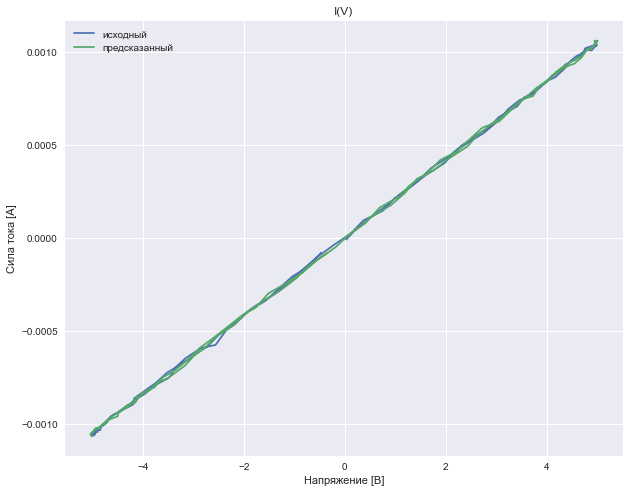

success: [95.58624897] -> 95.47045431627114 circuit D_R
SUCCESS:


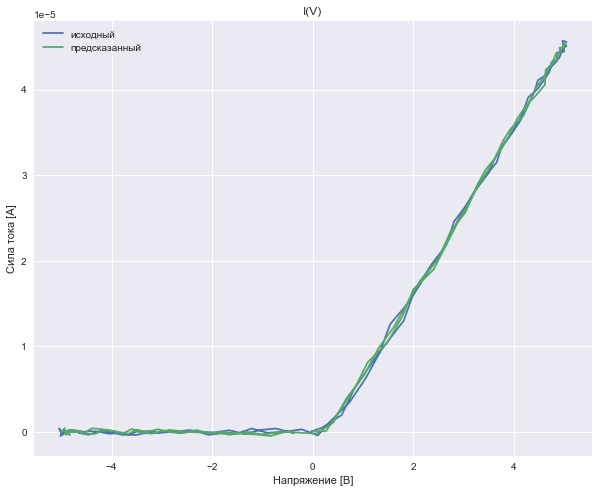

success: [1.86451519] -> 1.8124946489530225 circuit R
SUCCESS:


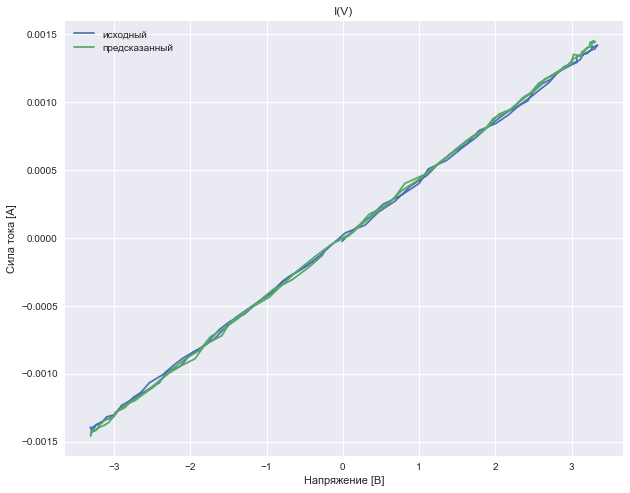

success: [34.3930982] -> 34.150362322048935 circuit D_R
SUCCESS:


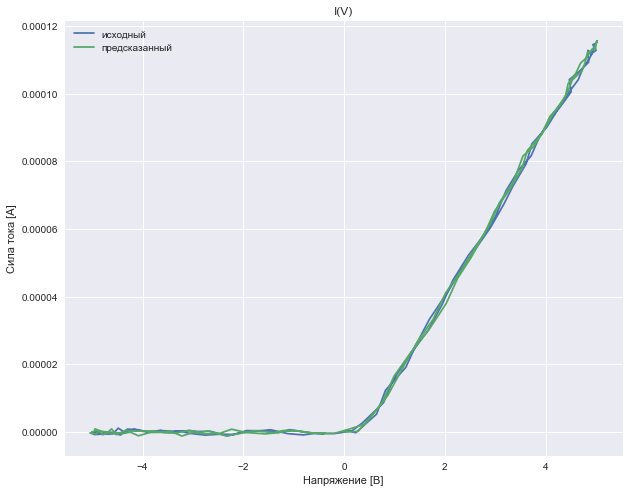

success: [74.63025809] -> 217.46701465607416 circuit L
SUCCESS:


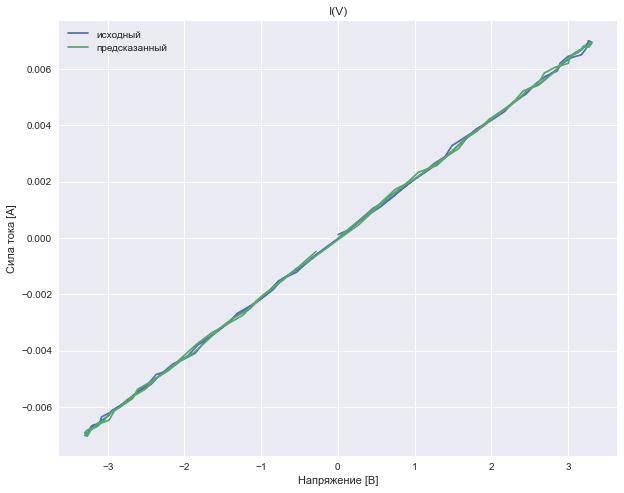

success: [5.02472947] -> 4.876542160561773 circuit R
SUCCESS:


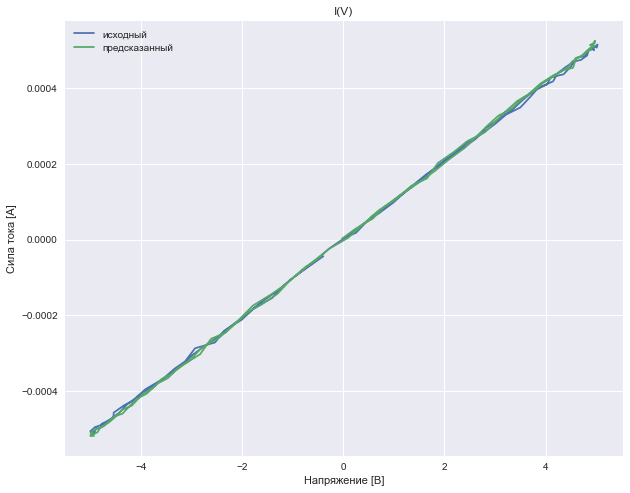

!!fail:  [8.0109168] -> [1.25295301 6.05965083] R detected like DR_R
FAIL:


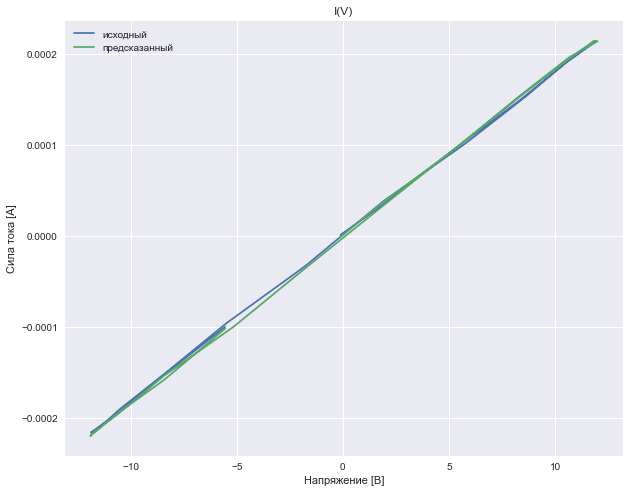

success: [5.64019228] -> 169.18511183707372 circuit L
SUCCESS:


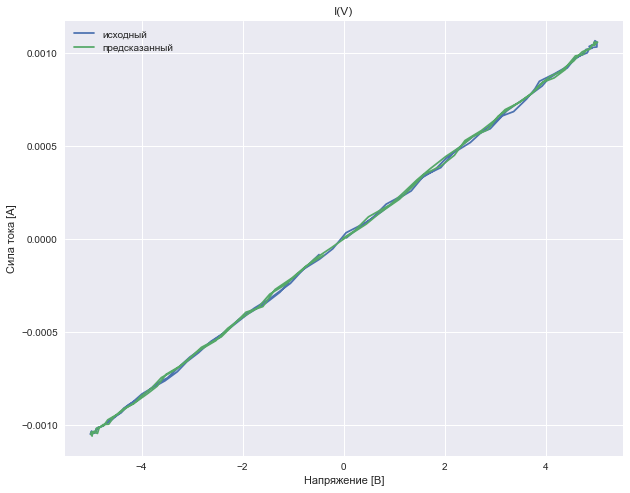

success: [88.65233441] -> 88.54917894146357 circuit D_R
SUCCESS:


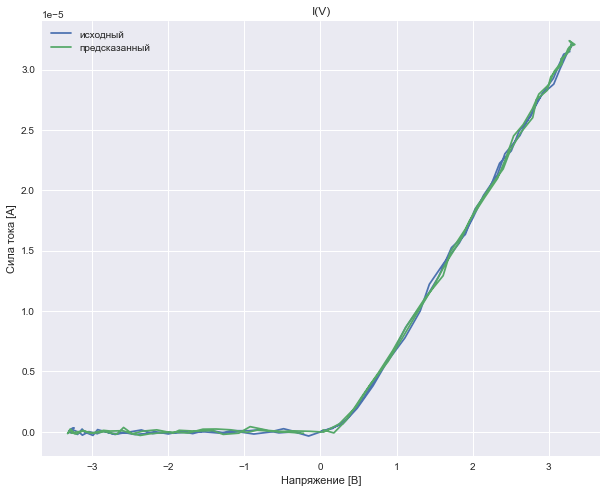

!!fail:  [7.64835313] -> [59.94057733  8.92628247] C detected like RC
FAIL:


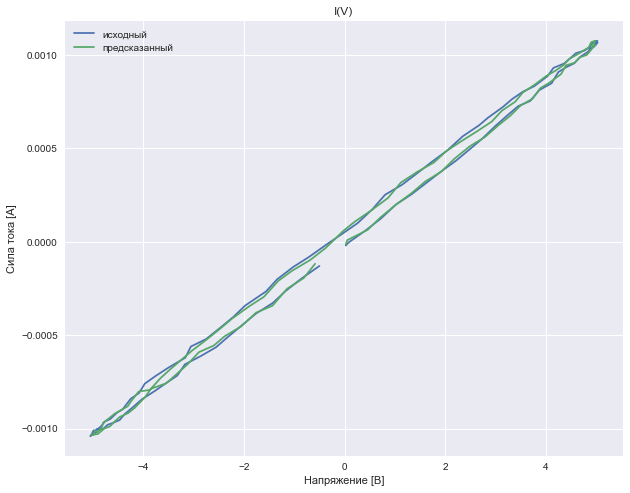

success: [42.28723196] -> 42.478732557856766 circuit DR
SUCCESS:


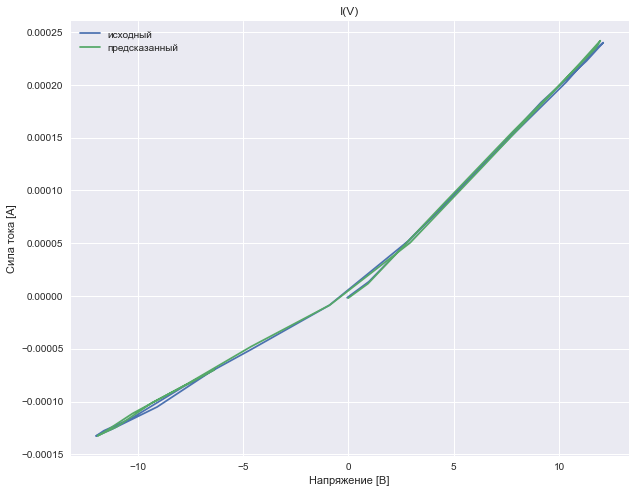

success: [33.43090997] -> 170.12535821402278 circuit L
SUCCESS:


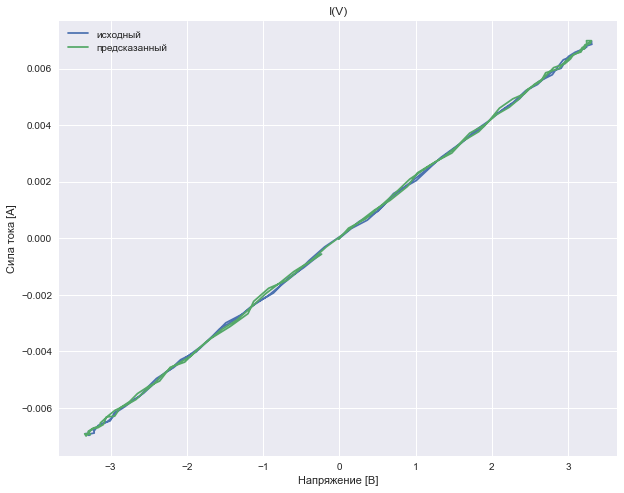

success: [75.48449135] -> 74.61020496686118 circuit D_R
success: [26.20803207] -> 159.5055156320565 circuit L
success: [5.3503442] -> 5.061739389992962 circuit D_R
success: [40.28712379] -> 40.928535564265886 circuit D_R
success: [91.85082239] -> 91.92545651459511 circuit C
success: [20.8962606] -> 135.93996167731444 circuit L
success: [59.2404462] -> 47.70438528407812 circuit C
success: [67.24558251] -> 69.41639054457391 circuit DR
!!fail:  [77.43961172] -> [ 0.52677392 54.12924059] C detected like R_C
FAIL:


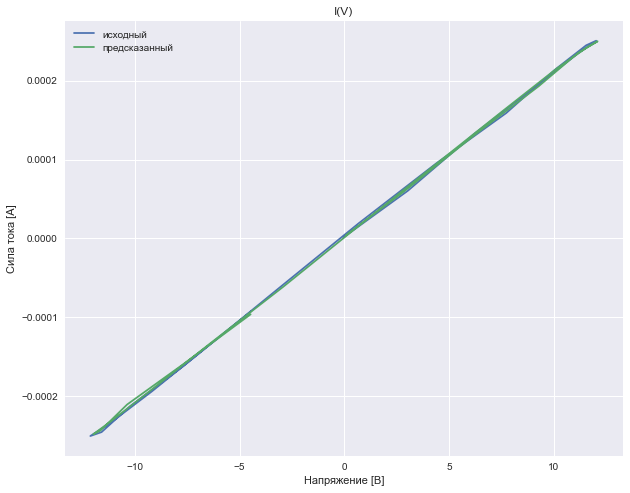

success: [87.22903058] -> 87.22264865772053 circuit D_R
success: [20.64527074] -> 21.46927820351309 circuit R
success: [51.33159528] -> 51.89112353646229 circuit C
!!fail:  [20.90577851] -> [96.94797758 20.71720277] C detected like RC
FAIL:


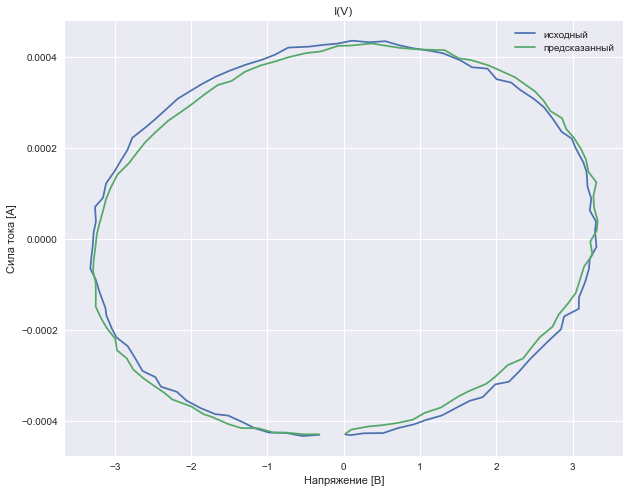

success: [78.04994498] -> 84.92207341099862 circuit DR
success: [65.7426127] -> 66.01456858311171 circuit D_R
success: [42.53762495] -> 62.14964064415791 circuit C
success: [16.21229069] -> 174.25017385249052 circuit L
success: [85.13307434] -> 295.48613072328897 circuit L
success: [70.25230594] -> 73.38409408668538 circuit DR
success: [33.75792995] -> 33.04118878542479 circuit R
success: [13.58342444] -> 12.949971682459424 circuit DR
success: [49.17977332] -> 48.230992262175995 circuit C
success: [30.33600188] -> 31.204834155958313 circuit R
success: [68.28374707] -> 67.52970774699077 circuit DR
success: [19.10279002] -> 19.751502034760307 circuit R
!!fail:  [94.39450634] -> 444.4219797209819 C detected like L
FAIL:


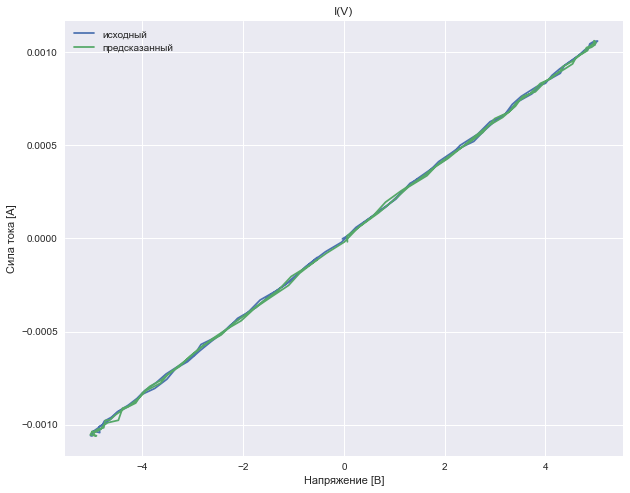

success: [60.88380627] -> 61.03243103892506 circuit R
success: [65.69876679] -> 65.49766107950381 circuit R
!!fail:  [36.11723381] -> [ 1.94423417 33.70507998] R detected like DR_R
FAIL:


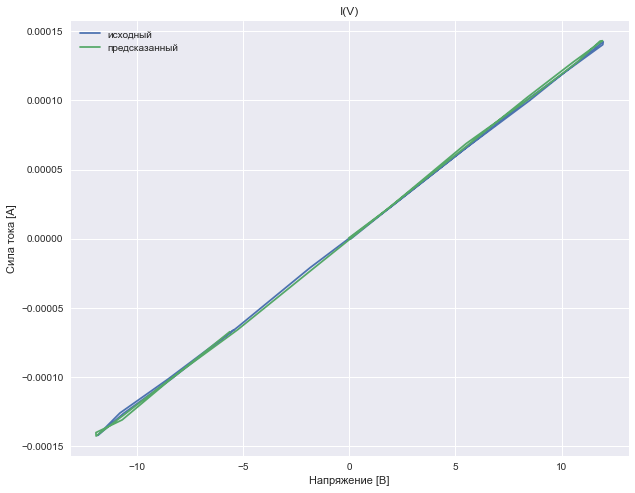

success: [35.40011896] -> 37.555125468999805 circuit D_R
!!fail:  [32.6327106] -> 40.6977692075811 L detected like C
FAIL:


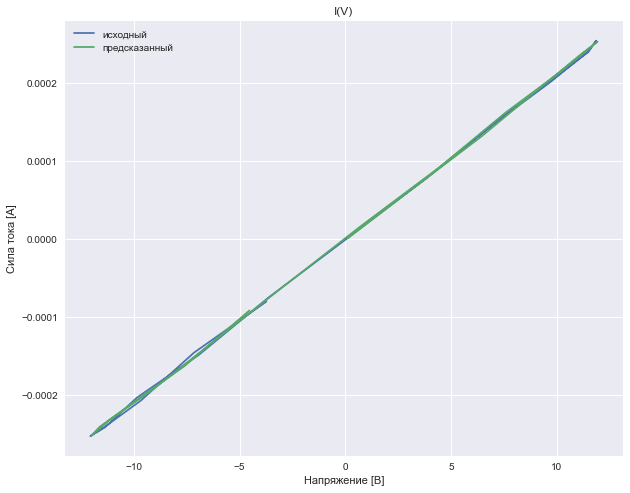

success: [49.32720863] -> 48.77277072329989 circuit C
success: [87.02422513] -> 116.09833099373942 circuit L
success: [75.4861133] -> 76.07493619796304 circuit D_R
success: [21.3854388] -> 186.172926086898 circuit L
success: [25.36690517] -> 26.4350177383453 circuit DR
success: [86.20458721] -> 77.20216245596022 circuit C
success: [48.27958655] -> 47.79725281351876 circuit DR

SUCCESS: 43, FAIL: 7 of 50 tests
RANK2 CIRCUIT TESTING ..
success: [42.53309761 68.49943091] -> [43.05292253 72.25657493] circuit R_C
SUCCESS:


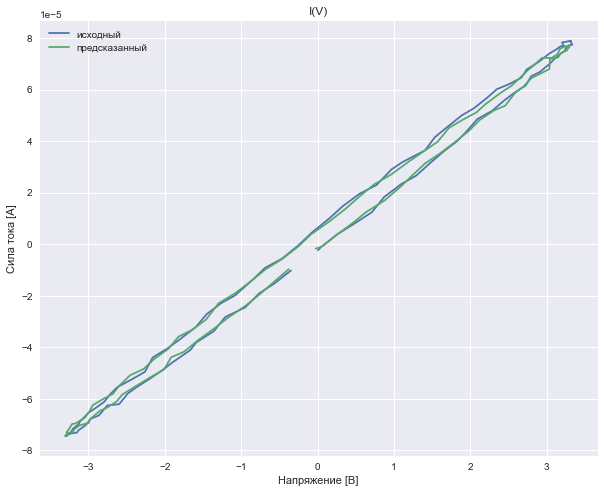

success: [78.3056983  65.54846188] -> [60.96493893 37.1496987 ] circuit RC
SUCCESS:


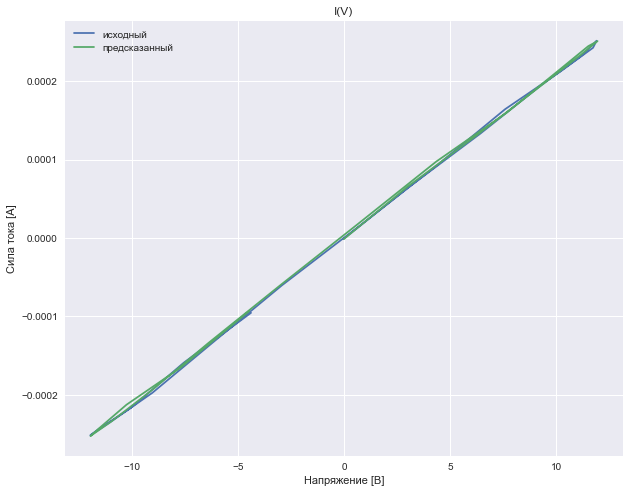

success: [59.17064217 59.95566281] -> [60.83511175 56.84071313] circuit R_C
SUCCESS:


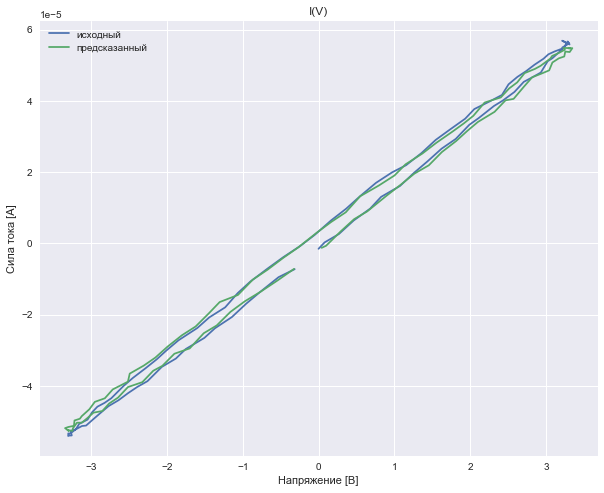

success: [77.78585943 76.19961048] -> [81.26421896 76.15842799] circuit DR_R
SUCCESS:


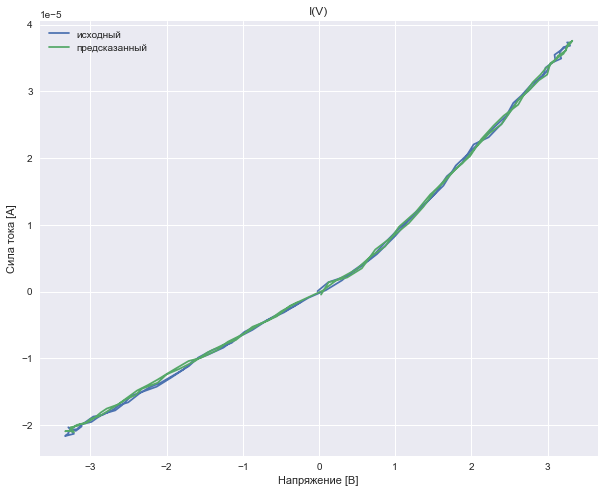

success: [57.84472767 25.78318364] -> [58.08805173 62.25448947] circuit R_C
SUCCESS:


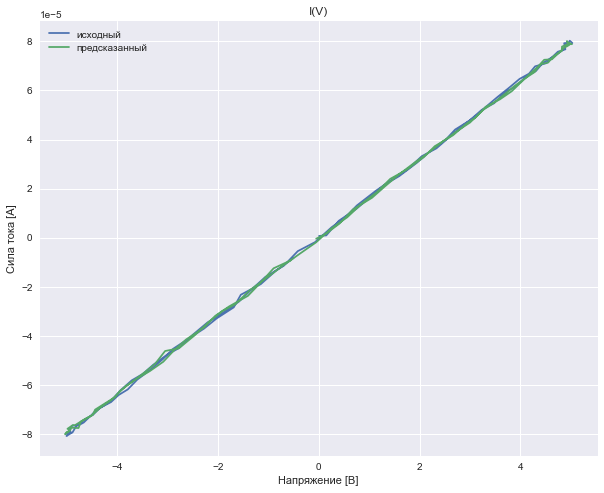

success: [27.0076649  69.64887777] -> [27.24002252 69.89721694] circuit DR_DR
SUCCESS:


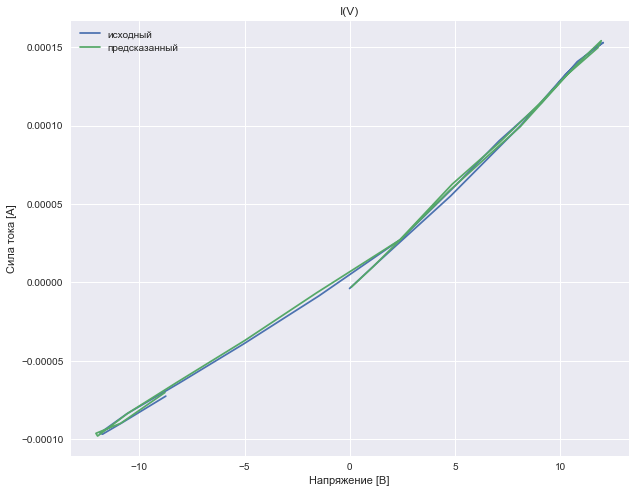

success: [98.02519281  9.57653634] -> [96.4904566   9.97459966] circuit R_C
SUCCESS:


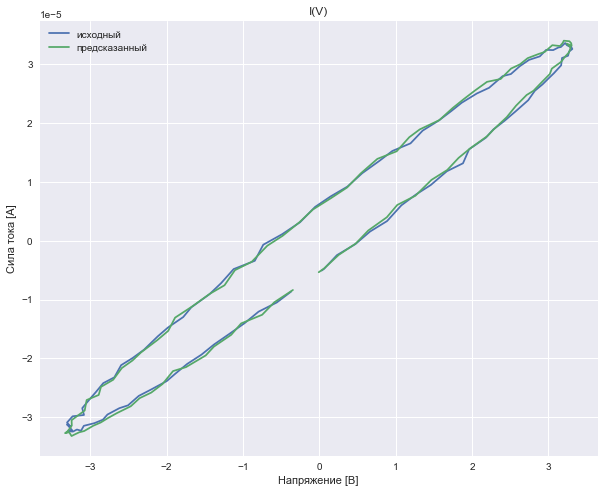

!!fail:  [41.5660191  78.09447502] -> [ 0.4834766  48.16474585] RC detected like R_C
FAIL:


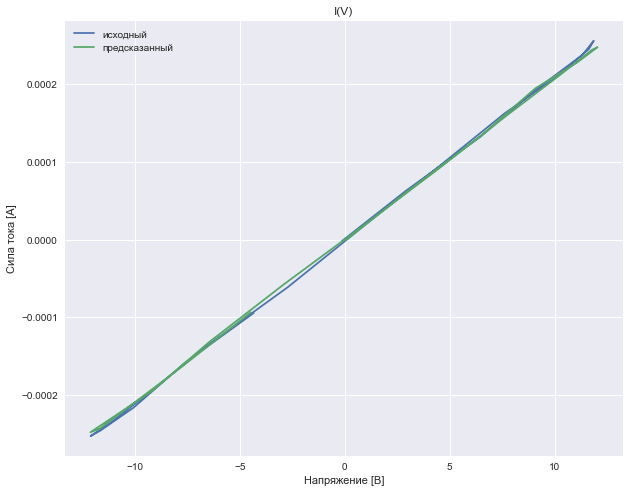

success: [62.6199985  26.10852552] -> [62.18606677 25.87710612] circuit DR_DR
SUCCESS:


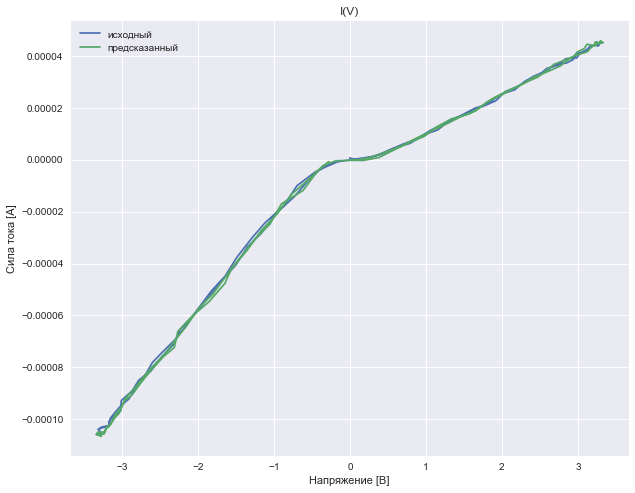

!!fail:  [84.24685557 39.5588317 ] -> 72.28819885835266 RC detected like C
FAIL:


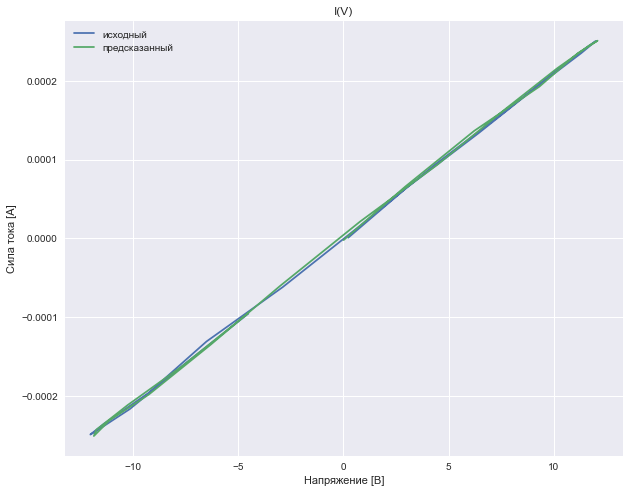

success: [82.20443014 74.1563883 ] -> [82.14430168 74.83567582] circuit DR_DR
SUCCESS:


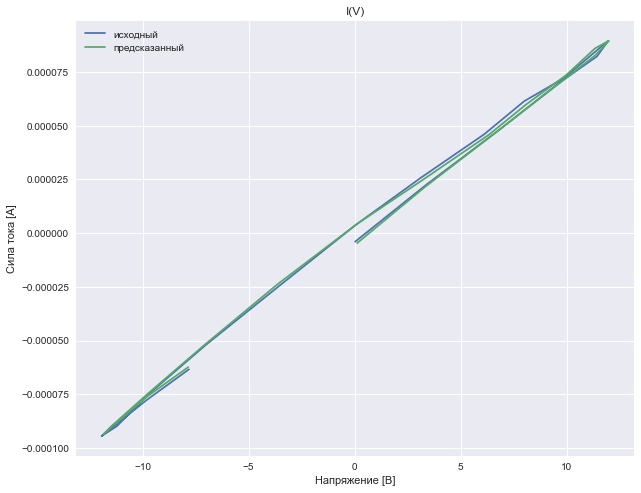

success: [63.93901868 63.02176065] -> [64.20704119 48.22656906] circuit R_C
SUCCESS:


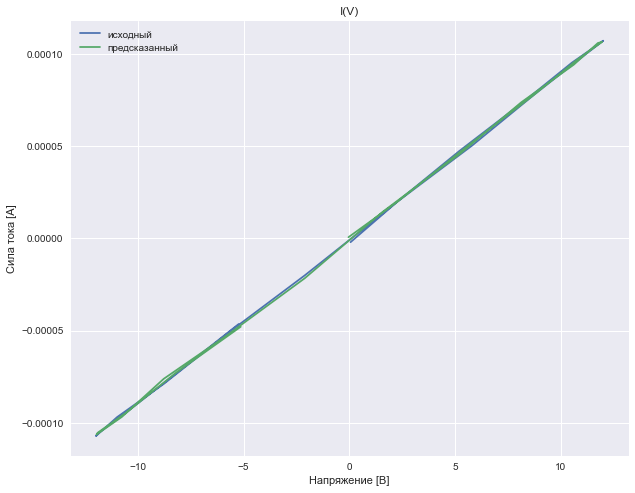

success: [90.64503613 23.36708675] -> [90.39457122 24.23637036] circuit R_C
success: [28.58883145 40.992467  ] -> [30.27894516 40.94148878] circuit DR_R
success: [22.26735148 32.55862944] -> [24.18546778 32.57386203] circuit DR_R
success: [80.7826258  15.53316252] -> [80.07603554 15.95853618] circuit DR_R
success: [34.60339553 82.6749686 ] -> [35.75929773 81.60012356] circuit RC
success: [74.41793636 67.4057797 ] -> [74.70486482 66.91793516] circuit DR_DR
success: [44.3099278  18.27059966] -> [43.8749288  17.71309933] circuit DR_DR
success: [92.7909176  37.92722407] -> [92.97449333 52.98155562] circuit R_C
success: [60.85815494 20.40509972] -> [66.0583706  18.43609969] circuit RC
!!fail:  [94.67697374 60.63691631] -> [60.1170289  99.01297466] DR_R detected like DR_DR
FAIL:


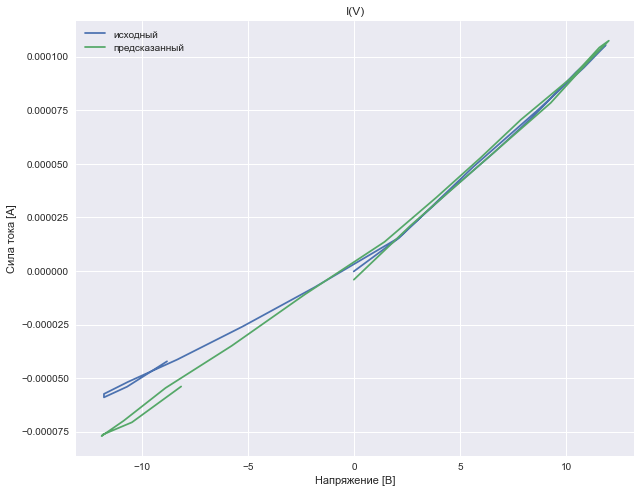

success: [25.71138107 13.87800984] -> [21.8116236  13.75898481] circuit DR_R
success: [64.34689973 76.66987958] -> [64.56867706 77.71546845] circuit DR_DR
success: [26.34386935  8.75790064] -> [26.81118446  9.36546579] circuit DR_DR
success: [25.71468347 78.97748682] -> [25.2330794  78.50643259] circuit R_C
!!fail:  [46.37475122 83.12279697] -> 76.33993790627092 RC detected like C
FAIL:


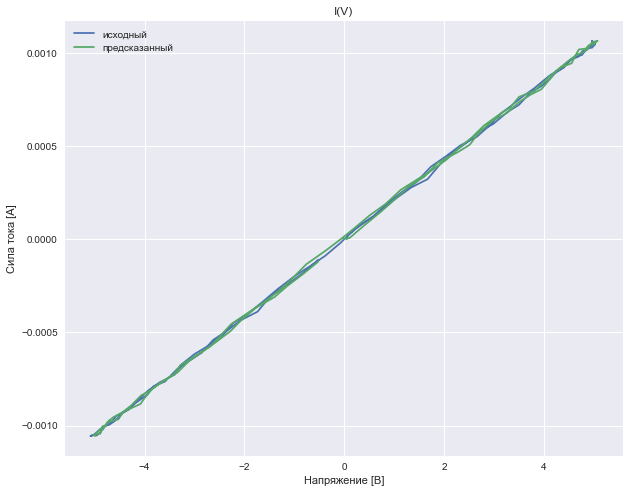

success: [ 1.68973906 34.5397454 ] -> [ 1.64898789 54.73142532] circuit R_C
success: [94.44304999 73.692663  ] -> [94.46783494 23.21816128] circuit R_C
success: [78.86180506  8.98071816] -> [78.45871007  9.02468602] circuit DR_R
success: [48.92425087 14.58730605] -> [55.57834652 14.49924645] circuit RC
success: [95.85623533 67.87016461] -> [96.49894067 65.19612276] circuit R_C
!!fail:  [17.55109194 97.29390643] -> [88.02735772 17.27628835] DR_DR detected like DR_R
FAIL:


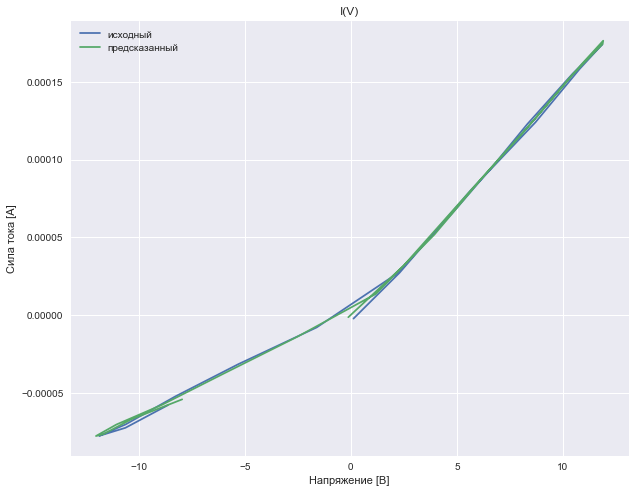

success: [94.16181744 33.68678316] -> [92.72518916 33.4789061 ] circuit DR_R
!!fail:  [2.95645531e+01 1.72919452e-02] -> [56.5892424  -0.06999927 68.22110411] DR_DR detected like DR_DR_R
FAIL:


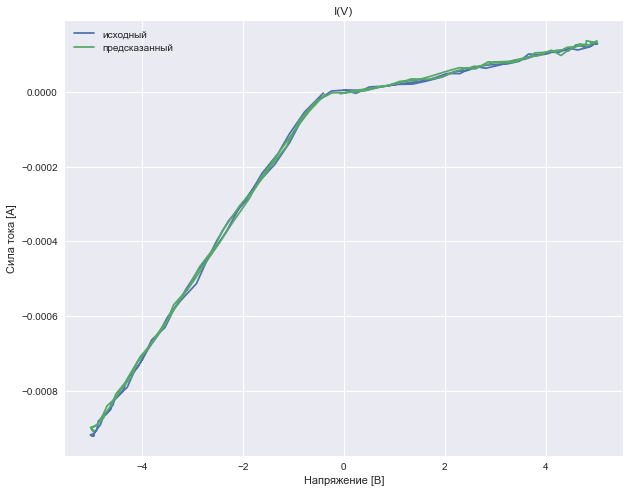

success: [69.66910831 73.63658051] -> [69.47912787 51.75990203] circuit R_C
!!fail:  [ 8.6550231 10.8330951] -> [33.85662004  8.01718711] R_C detected like RC
FAIL:


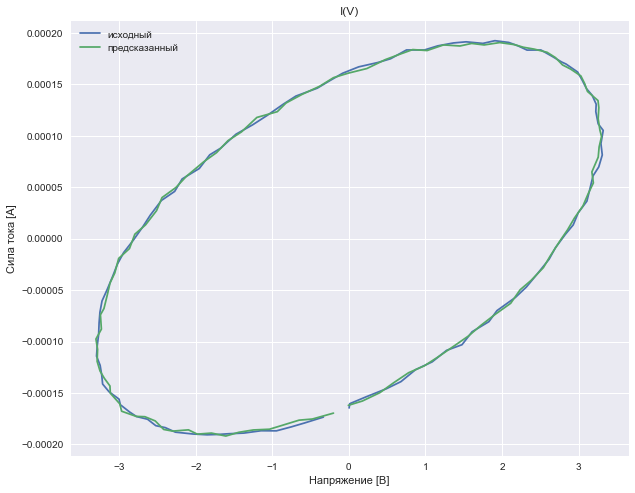

success: [52.09744545 41.56414919] -> [52.45011821 41.27824699] circuit DR_DR
success: [46.56932239 57.75493357] -> [46.53464495 64.91555755] circuit R_C
success: [88.40118372 68.04672076] -> [88.60417199 65.8885667 ] circuit R_C
success: [92.12081416 32.71688877] -> [89.27187829 33.36687114] circuit DR_R
!!fail:  [24.73205212 46.59351746] -> [ 26.04397264  78.24733309 104.42771327] DR_DR detected like DR_DR_R
FAIL:


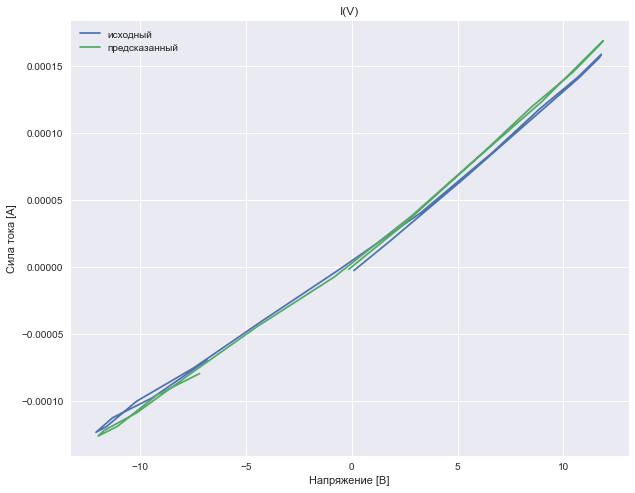

success: [61.04332106 93.95530761] -> [61.21532756 94.08937263] circuit DR_DR
success: [51.193822   11.33310169] -> [50.69622593 11.6901167 ] circuit DR_DR
success: [51.30018016 76.31358396] -> [54.92343163 75.66088806] circuit DR_R
!!fail:  [35.81206786 21.62295636] -> 48.64032533095143 RC detected like C
FAIL:


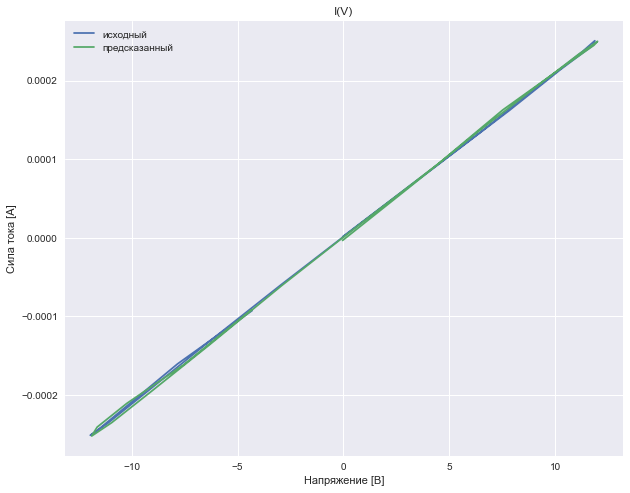

success: [41.38603239 41.87455271] -> [41.42066168 59.6674917 ] circuit R_C
success: [54.0296716  42.49554888] -> [53.54107323 42.91686729] circuit DR_DR
success: [43.94157596 29.79737499] -> [43.09882202 29.78534565] circuit DR_R
success: [ 5.12812698 82.52839219] -> [ 5.15541286 65.94600056] circuit R_C

SUCCESS: 41, FAIL: 9 of 50 tests
RANK3 CIRCUIT TESTING ..
!!fail:  [ 9.87762203 45.10859255 32.97317391] -> [ 7.17231284 16.52226092] DR_DR_R detected like DR_DR
FAIL:


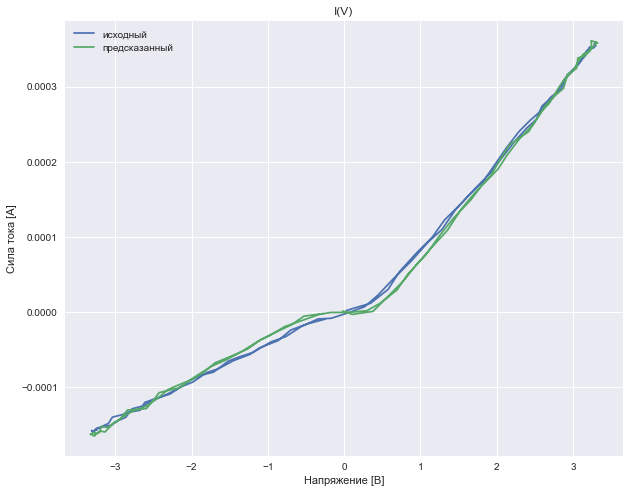

success: [77.17999026 64.48392773 16.08618743] -> [70.56773822 66.79813006 13.08844321] circuit DR_DR_R
SUCCESS:


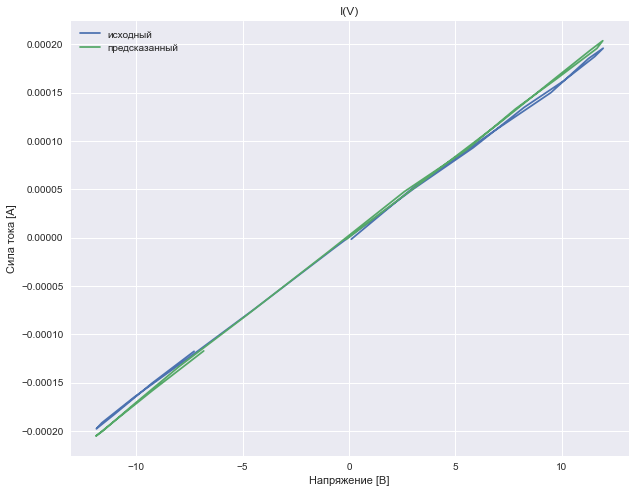

!!fail:  [76.48086562 74.76919962 15.24408843] -> [13.32117429  0.58674801] DR_DR_R detected like RC
FAIL:


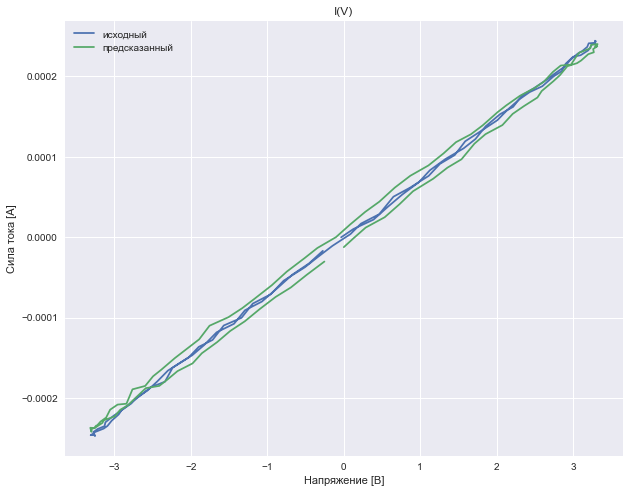

!!fail:  [14.61903253 29.93268469 22.13753396] -> [ 7.53350879 10.65810121] DR_DR_R detected like DR_DR
FAIL:


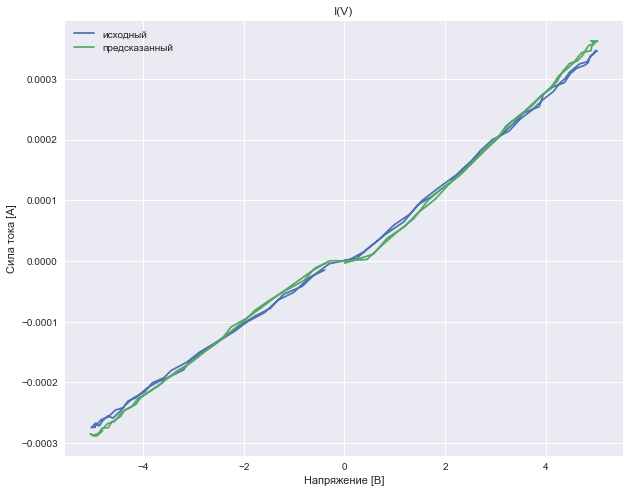

success: [ 8.0658551  65.68842394 95.45925754] -> [ 9.39394056 82.95198367 81.05126414] circuit DR_DR_R
SUCCESS:


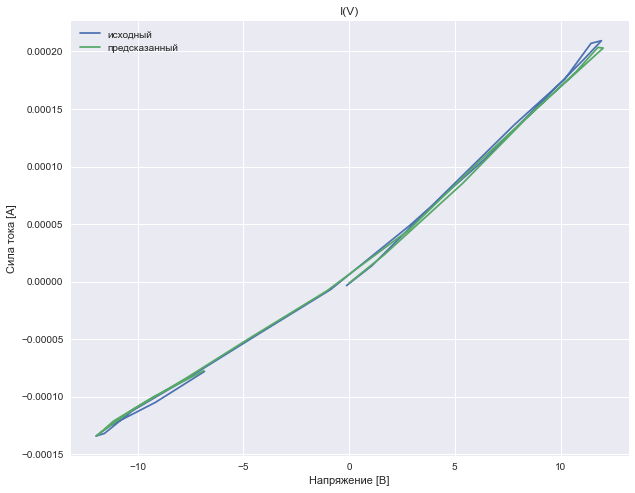

success: [89.98540241 27.0549907  52.80015506] -> [77.37939304 25.02095935 61.091168  ] circuit DR_DR_R
SUCCESS:


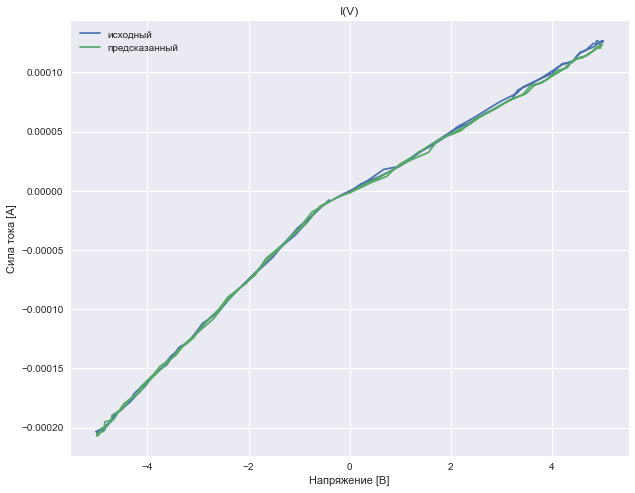

success: [65.24626106 85.44057299 54.14417856] -> [61.51803614 81.23172936 59.08170639] circuit DR_DR_R
SUCCESS:


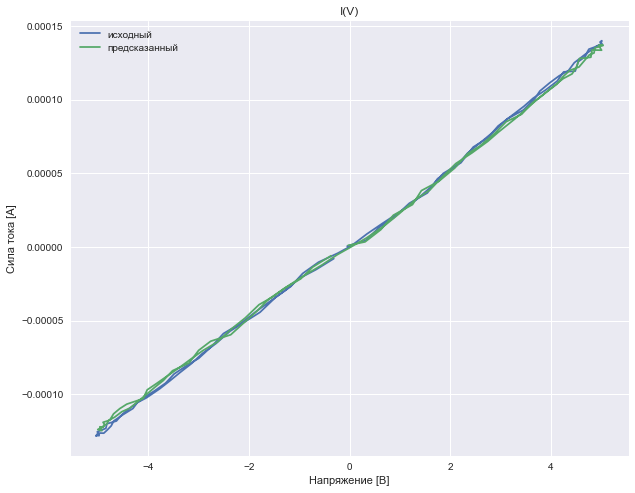

!!fail:  [19.20909376 26.67807045 93.9706545 ] -> [14.89520502 19.54516249] DR_DR_R detected like DR_DR
FAIL:


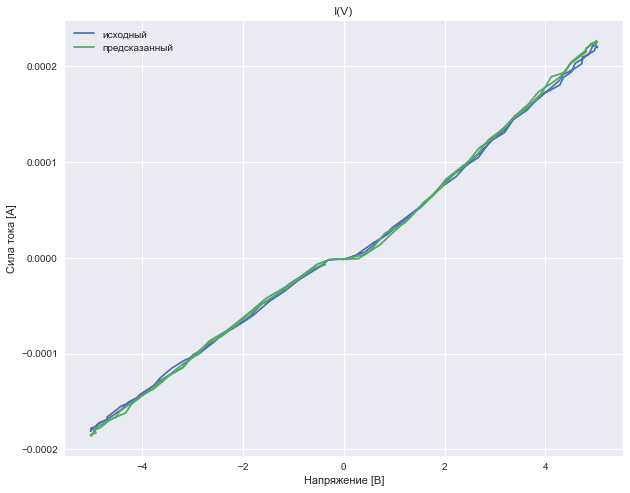

!!fail:  [ 2.37987034 43.03746368 81.3389314 ] -> [ 2.88883176 27.04416367] DR_DR_R detected like DR_DR
FAIL:


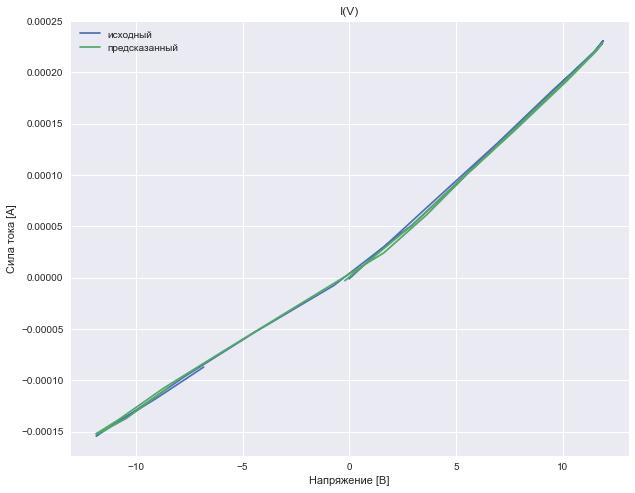

success: [62.16123089 70.17310069 44.54112471] -> [64.16835847 76.4101824  39.4362284 ] circuit DR_DR_R
SUCCESS:


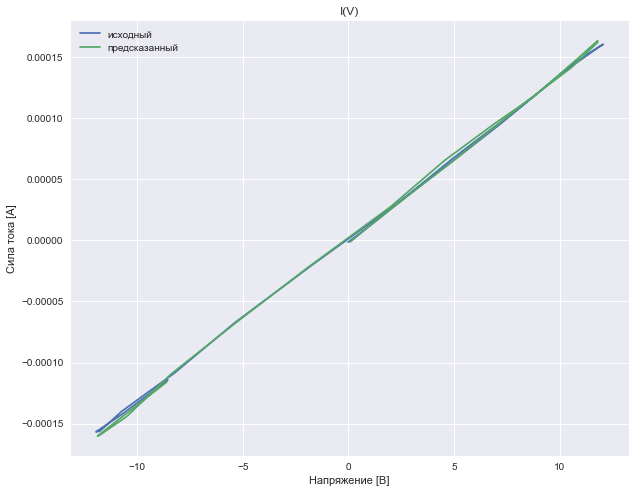

success: [98.54193222 94.43606787 61.80423756] -> [91.57713026 83.59777654 62.3564174 ] circuit DR_DR_R
SUCCESS:


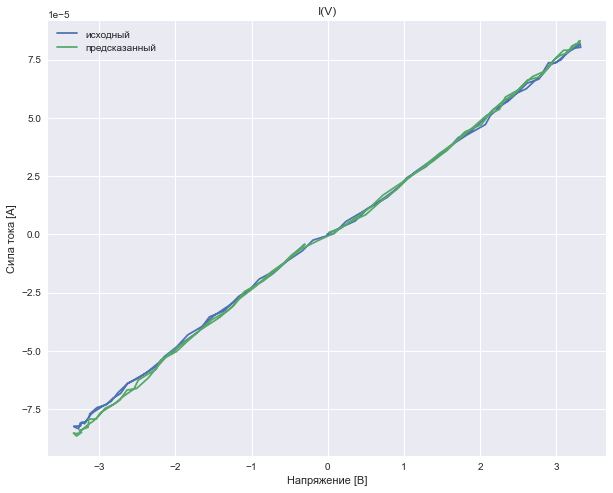

success: [60.01560244 97.83331115 56.39694459] -> [59.79968539 87.45756863 59.88256904] circuit DR_DR_R
SUCCESS:


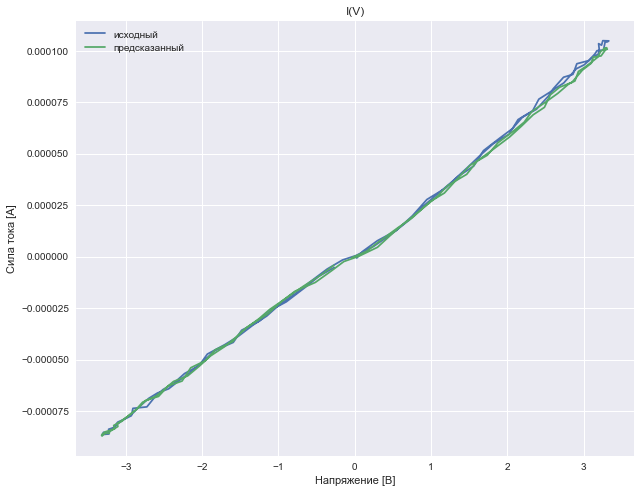

success: [70.70805671 50.72110317 29.73567331] -> [67.28231293 47.57873881 31.10316476] circuit DR_DR_R
SUCCESS:


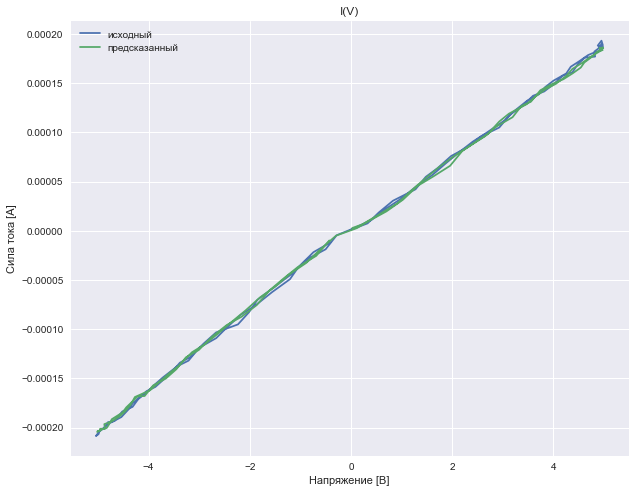

!!fail:  [38.27717786 40.41341025 30.20561724] -> 18.181280950491068 DR_DR_R detected like R
FAIL:


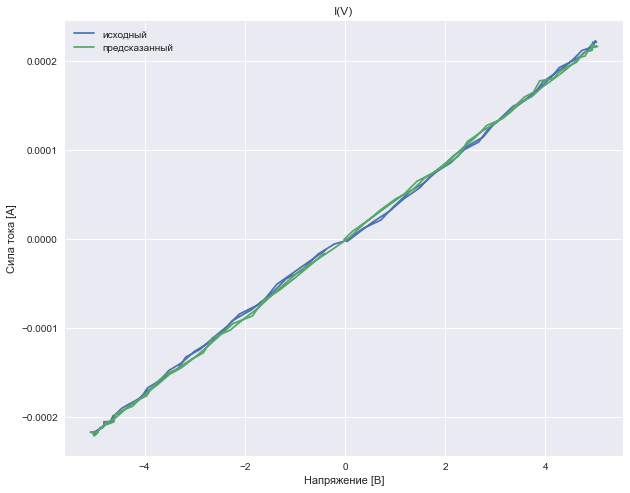

!!fail:  [10.85465261 26.63695092 51.59182975] -> [ 8.27738547 16.56463407] DR_DR_R detected like DR_DR
FAIL:


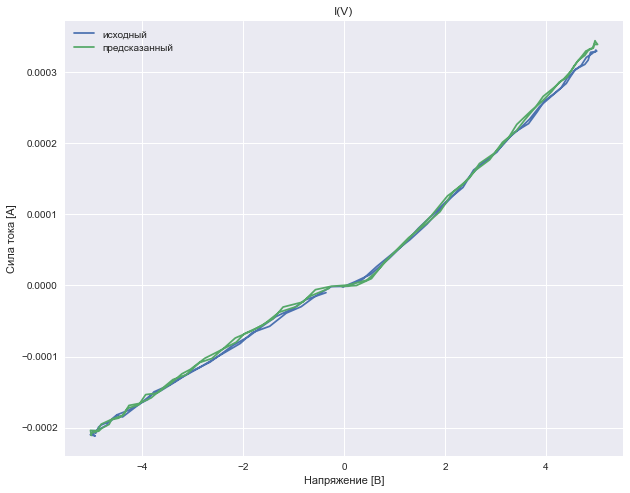

success: [36.86740176 76.05923301 13.99623174] -> [38.19707075 68.77637125 14.20191204] circuit DR_DR_R
SUCCESS:


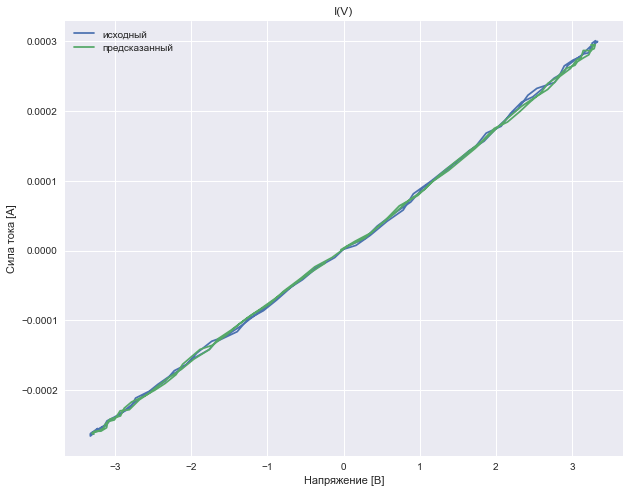

!!fail:  [20.20679403 86.46131006  6.26781193] -> [ 5.16854879 37.44585014] DR_DR_R detected like R_C
FAIL:


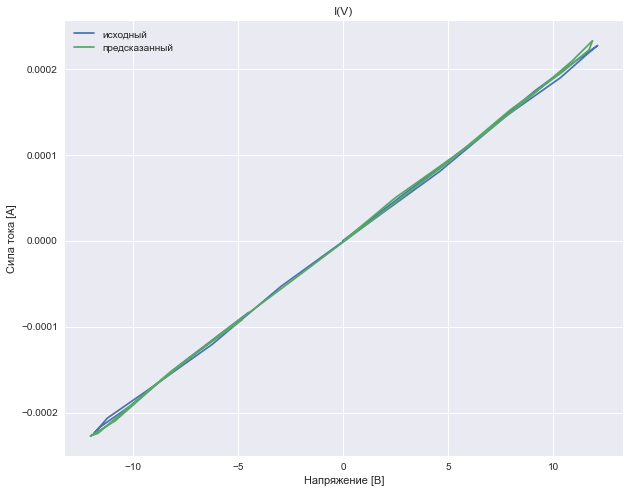

!!fail:  [63.79352752 25.89108174 48.67723787] -> [24.48032917 15.59892386] DR_DR_R detected like DR_DR
FAIL:


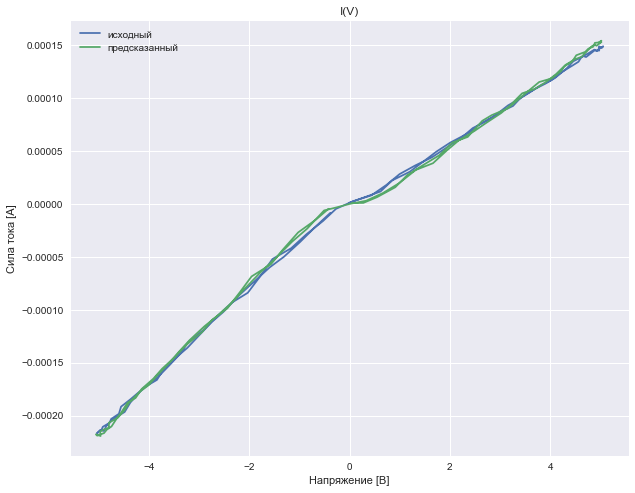

success: [86.58290781 89.90124188 68.52119974] -> [83.27730708 89.69495129 73.13926918] circuit DR_DR_R
SUCCESS:


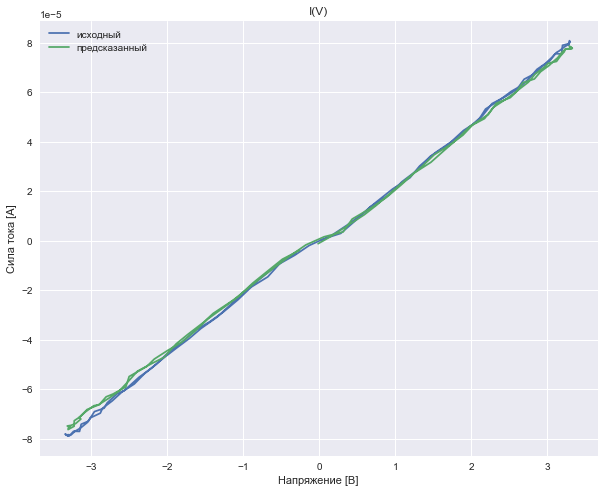

success: [48.10332319 48.46823618 82.1871447 ] -> [55.81982069 61.84185585 70.10191968] circuit DR_DR_R
success: [69.58057083 72.93529144 10.55537073] -> [76.11231494 77.53956923 10.4130053 ] circuit DR_DR_R
!!fail:  [30.17863241 71.65122964 98.11959151] -> [22.34462051 38.36706225] DR_DR_R detected like DR_DR
FAIL:


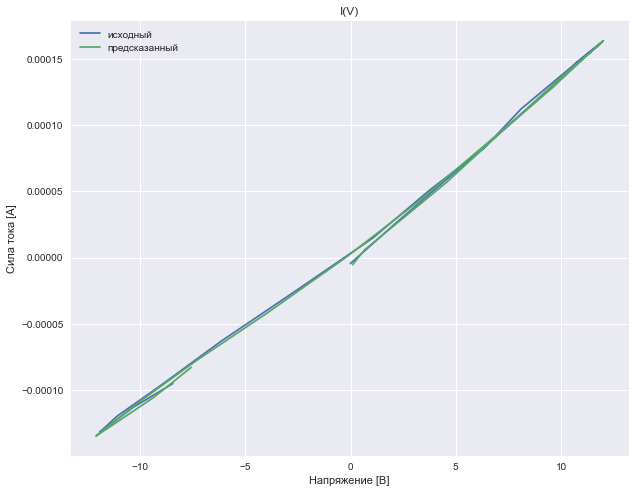

!!fail:  [79.97750507 72.85349558 27.6342407 ] -> [17.84949203 17.45057899] DR_DR_R detected like DR_DR
FAIL:


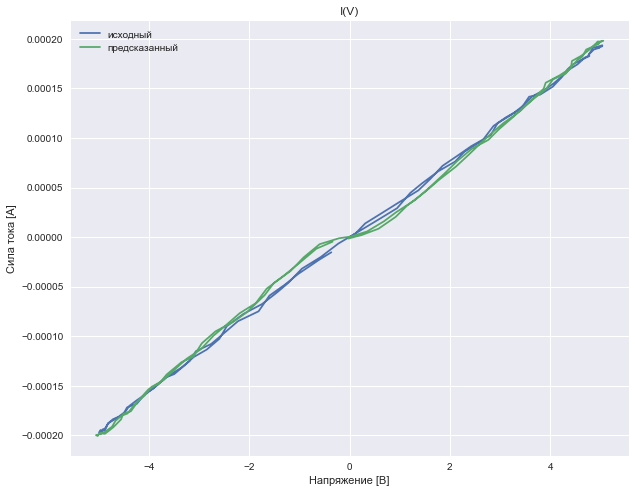

!!fail:  [72.8440857  21.75462851  0.64858368] -> 0.6081350353181084 DR_DR_R detected like R
FAIL:


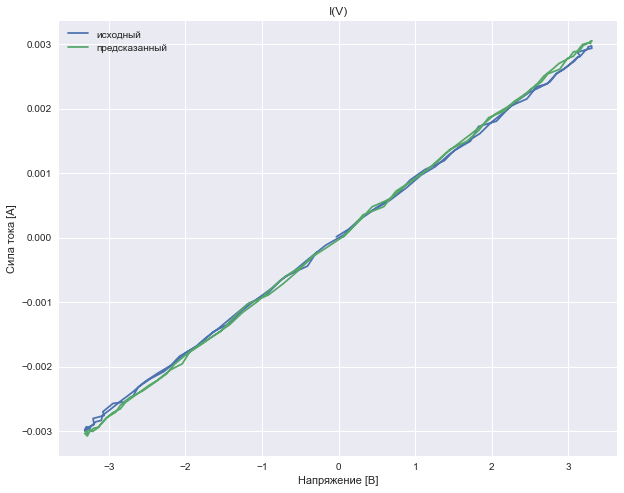

success: [21.48781416 22.8629427  84.06953341] -> [25.25680003 34.64031778 75.2097236 ] circuit DR_DR_R
success: [83.72615543 93.32145255 62.84623817] -> [76.45461552 86.82646209 71.08871435] circuit DR_DR_R
!!fail:  [19.69435681  5.55520961 19.82506524] -> [7.64220147 4.05140079] DR_DR_R detected like DR_DR
FAIL:


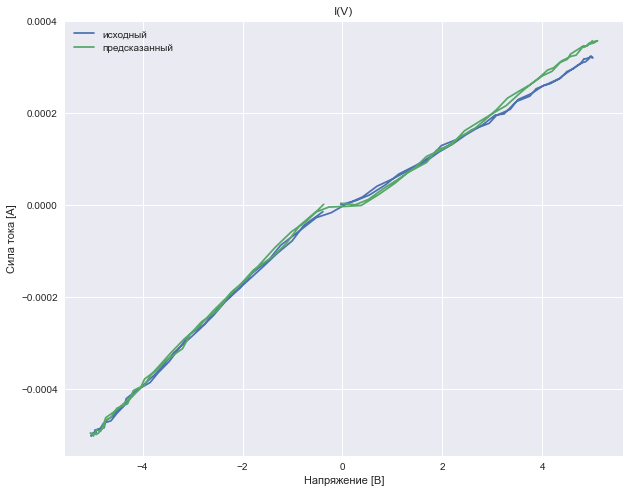

success: [77.90344963 82.18927686 90.35981211] -> [84.05572899 88.7353541  90.92170283] circuit DR_DR_R
success: [53.34657497 22.85632001 63.16385233] -> [59.15942813 21.39567987 66.88601621] circuit DR_DR_R
!!fail:  [45.300239   50.9515144  29.20990089] -> [18.54417199 73.54229766] DR_DR_R detected like R_C
FAIL:


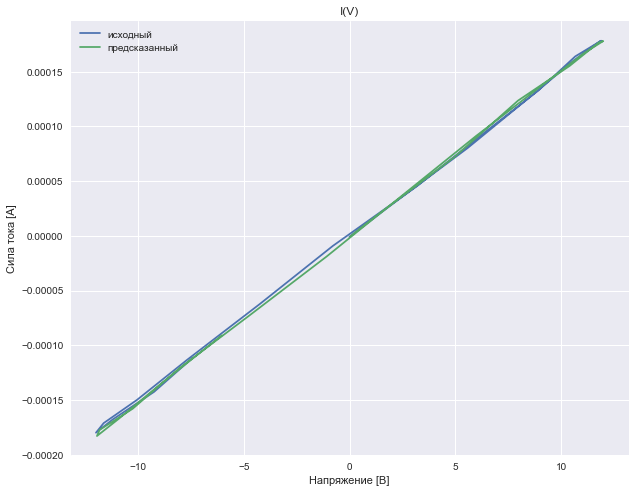

!!fail:  [ 4.01161266 89.75313251 88.74386647] -> [ 3.78182018 41.10689542] DR_DR_R detected like DR_DR
FAIL:


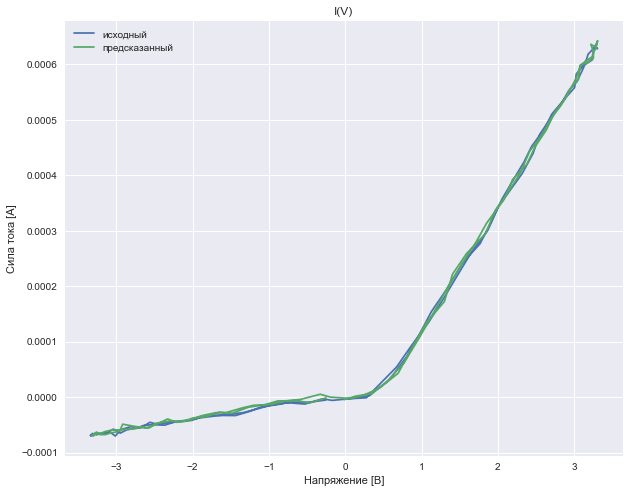

success: [70.15061103 49.82739785 65.6728682 ] -> [75.07886499 56.8409019  64.58651203] circuit DR_DR_R
!!fail:  [12.22065985  7.04269038 85.24999133] -> [10.42443467  6.25238315] DR_DR_R detected like DR_DR
FAIL:


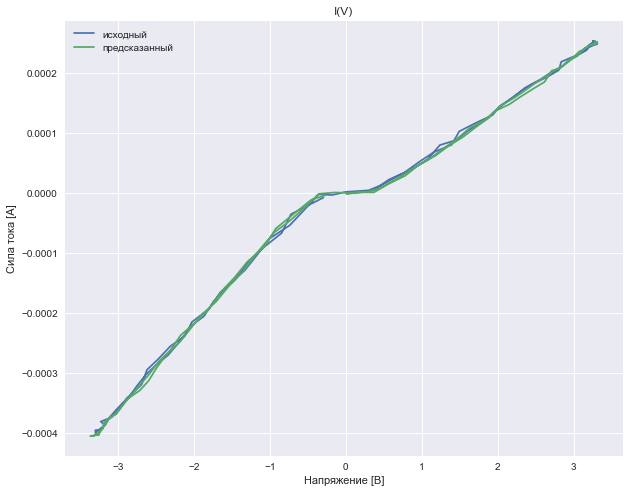

!!fail:  [84.9734509  40.58564169  2.43382953] -> 2.659778250212156 DR_DR_R detected like R
FAIL:


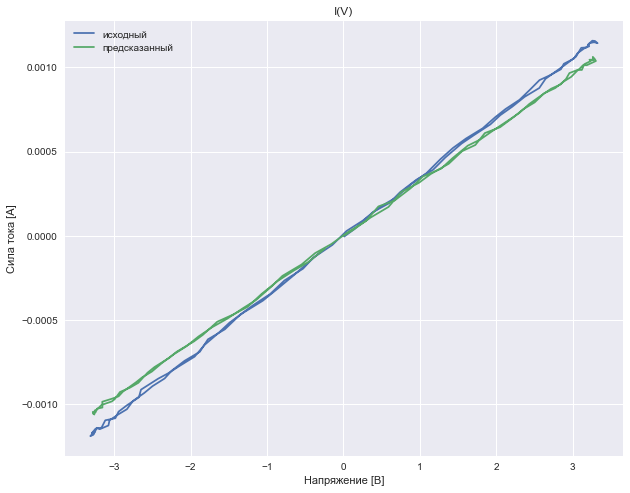

!!fail:  [12.27642229  7.66805106 31.68322006] -> [7.55426929 5.58257838] DR_DR_R detected like DR_DR
FAIL:


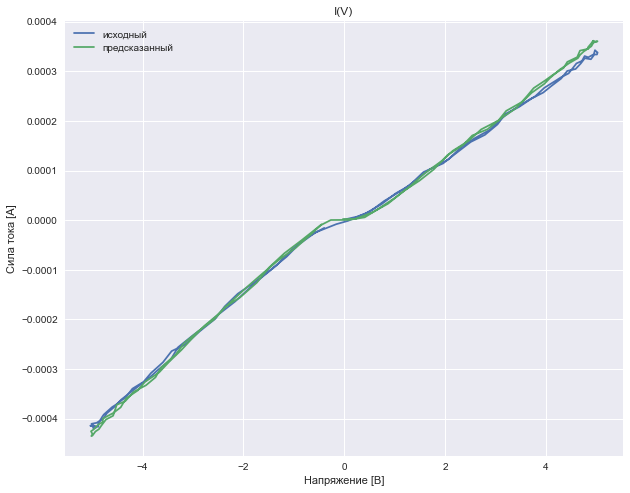

success: [54.89834001 82.07390962 13.8620082 ] -> [60.06064725 74.5262687  13.45449781] circuit DR_DR_R
success: [41.7715121  50.89119407 42.90237871] -> [46.47223615 57.82235746 41.8284979 ] circuit DR_DR_R
!!fail:  [60.8961011  35.57884752  2.13247233] -> 2.1599235979848537 DR_DR_R detected like R
FAIL:


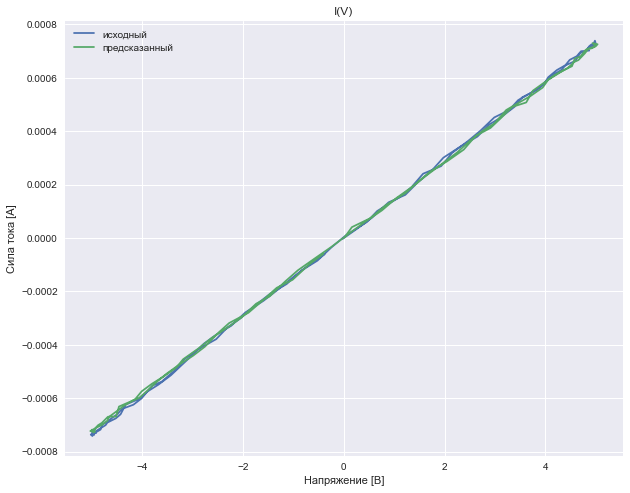

success: [24.93989808 34.95059591 71.45879357] -> [23.78301967 49.98873994 70.43571301] circuit DR_DR_R
!!fail:  [76.07170701 95.02103523  7.02428017] -> [ 5.4384422  55.89655281] DR_DR_R detected like R_C
FAIL:


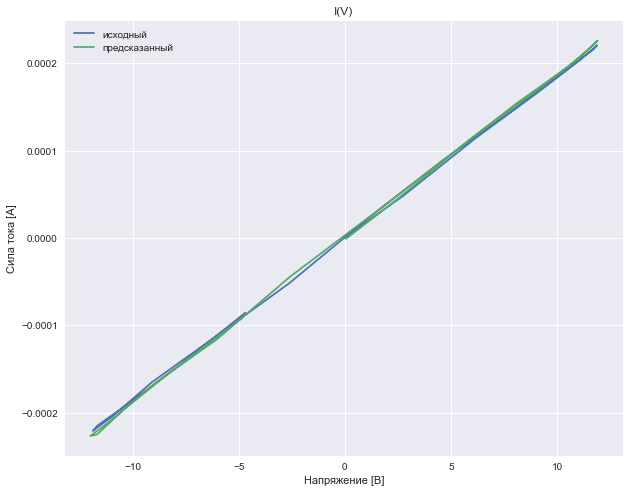

!!fail:  [ 9.48380377 67.88467032 51.37208058] -> [ 7.54734565 26.77704994] DR_DR_R detected like DR_DR
!!fail:  [48.05581536 78.68100207  1.5643422 ] -> 1.4522027176787748 DR_DR_R detected like R
!!fail:  [24.5594395  53.85181546 93.06702047] -> [18.00239979 32.05793728] DR_DR_R detected like DR_DR
success: [56.24783321 35.34786944 69.40125908] -> [65.80494243 44.72066188 62.09436335] circuit DR_DR_R
success: [62.58474589 80.73537258 92.0201878 ] -> [64.65837805 94.13064767 83.62251741] circuit DR_DR_R
success: [35.57170824 54.99860868 54.50203203] -> [32.94811951 54.77617224 56.61625234] circuit DR_DR_R
!!fail:  [11.69866231 34.03326486 47.73855409] -> [16.02274748 64.50762599] DR_DR_R detected like R_C
!!fail:  [29.22160452 19.56912571 35.2703235 ] -> [14.00954036 11.12110427] DR_DR_R detected like DR_DR
!!fail:  [44.51455189 82.82101454 95.90123941] -> [29.2725416  42.33973903] DR_DR_R detected like DR_DR
!!fail:  [18.75812935 96.18482493 34.4290405 ] -> [11.39980216 20.61202995] D

In [17]:
%%time
cre.test_me()

### Тесты на реальных приборных Данных

**file E:\EyePoint\RealSignalFolder\100hz.json
F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


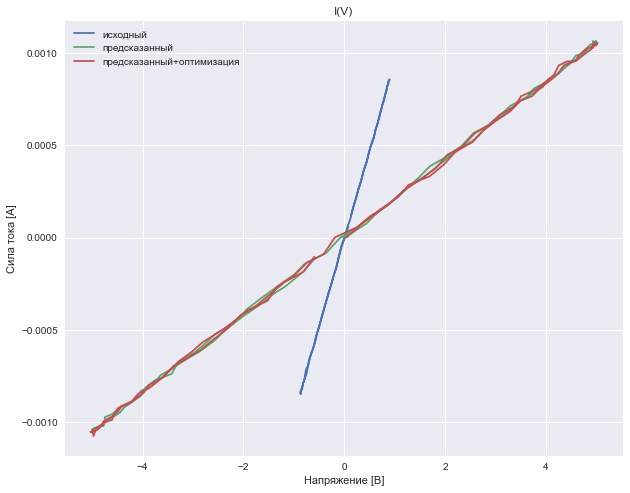

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


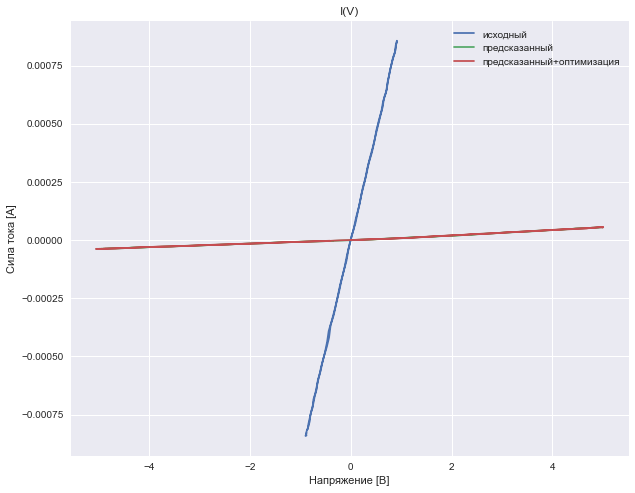

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


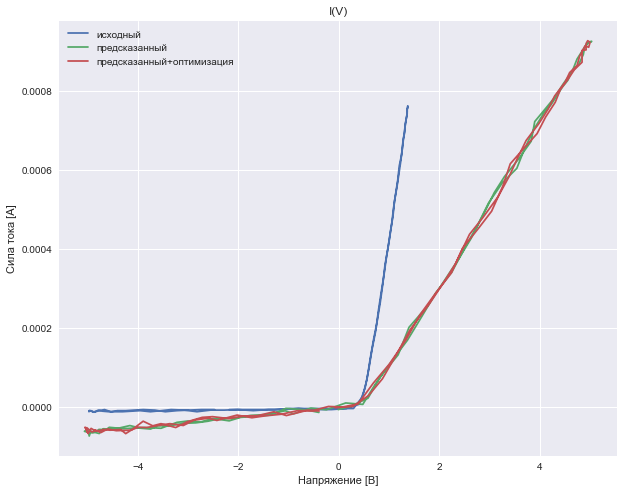

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


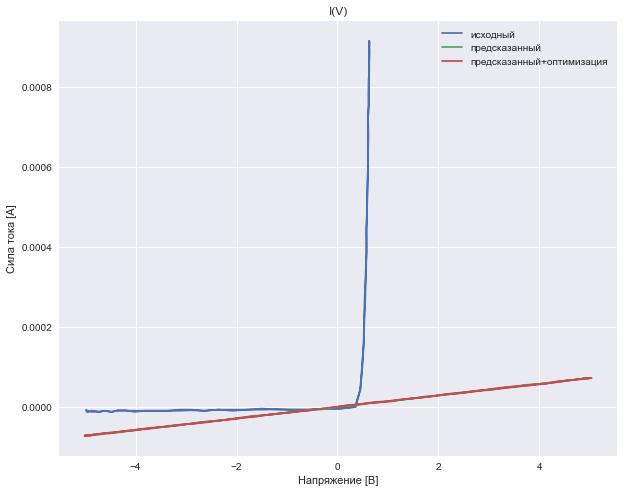

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


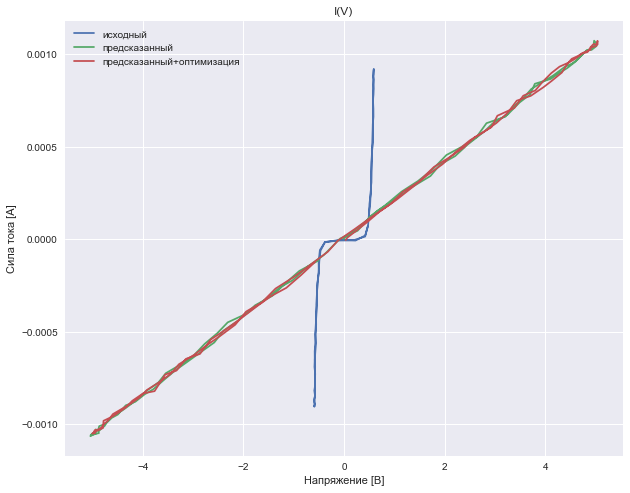

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


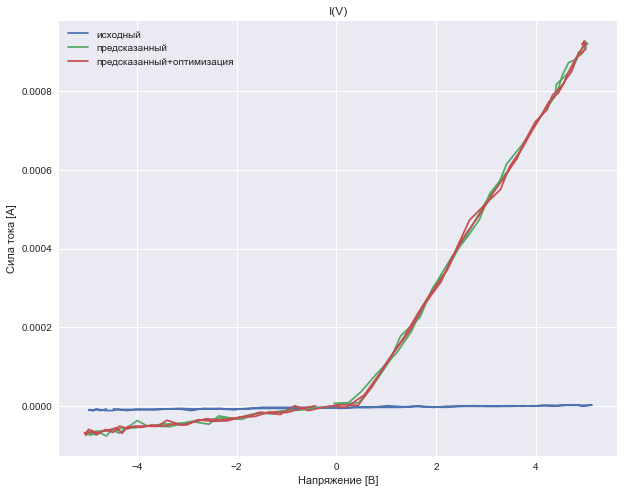

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


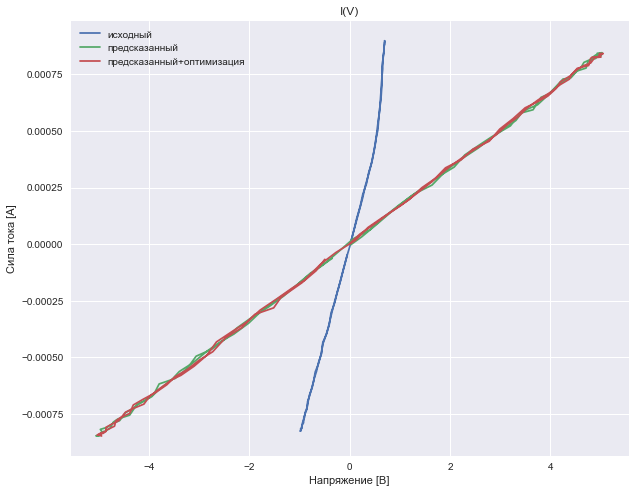

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


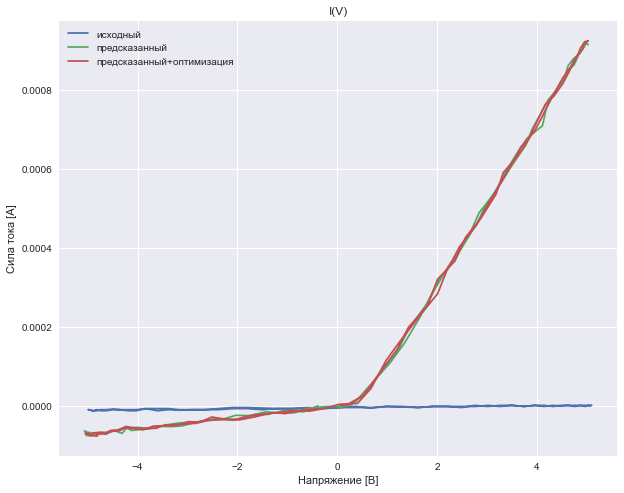

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


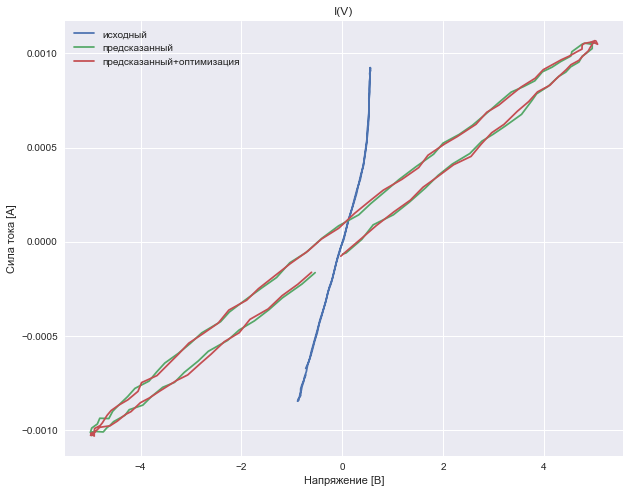

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


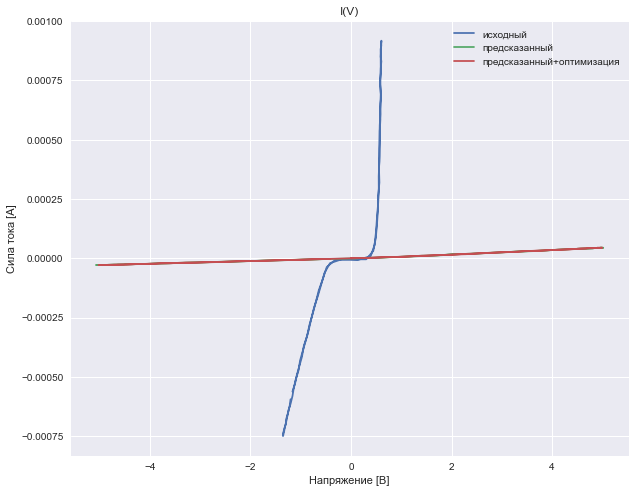

**file E:\EyePoint\RealSignalFolder\1hz_2020.json
F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


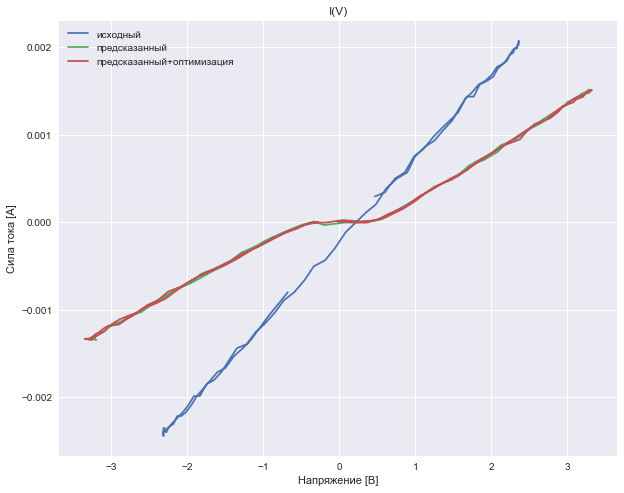

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


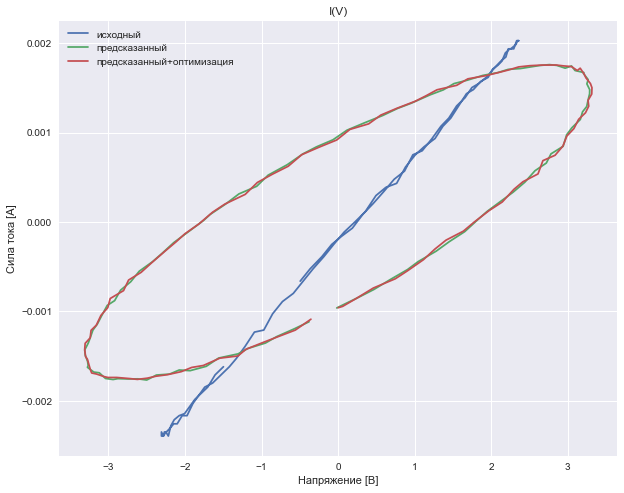

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


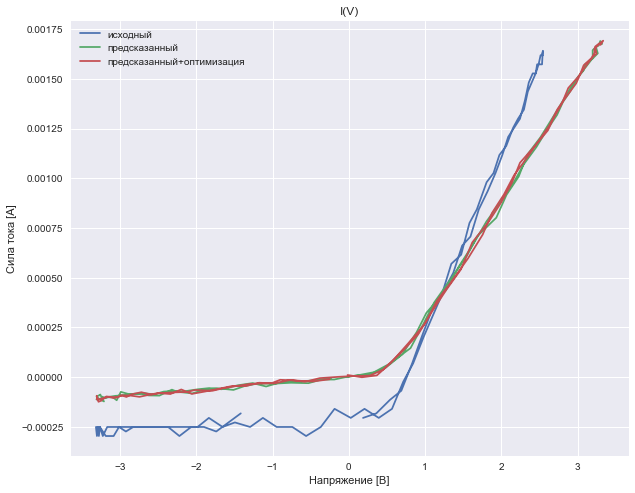

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


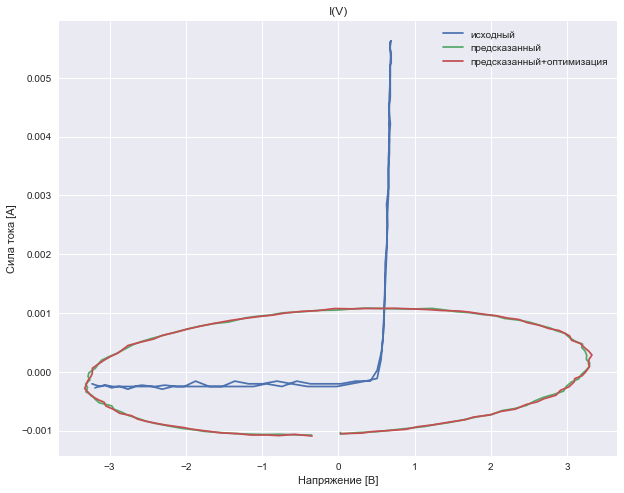

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


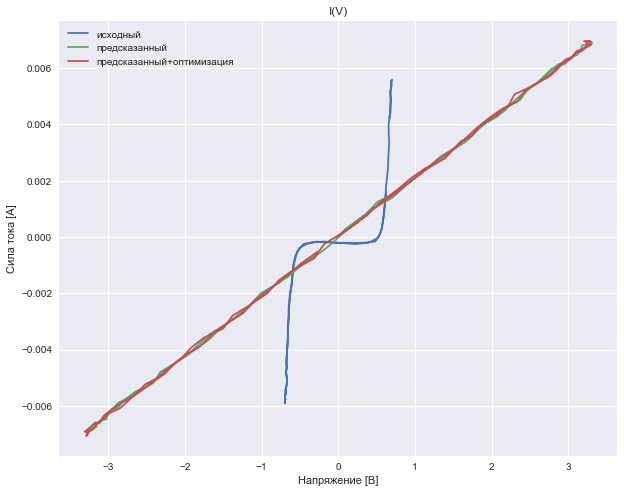

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


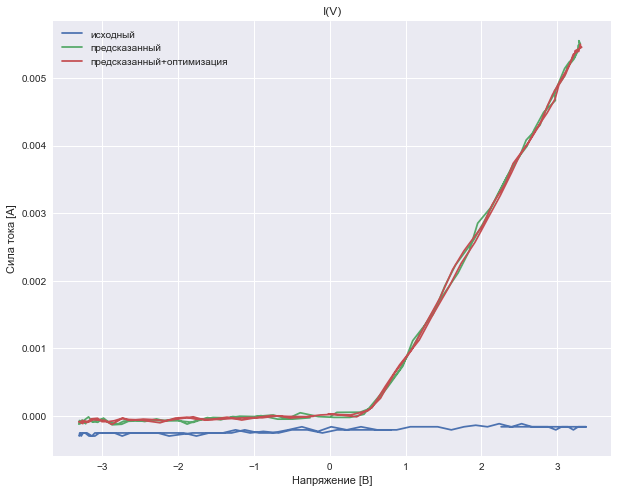

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


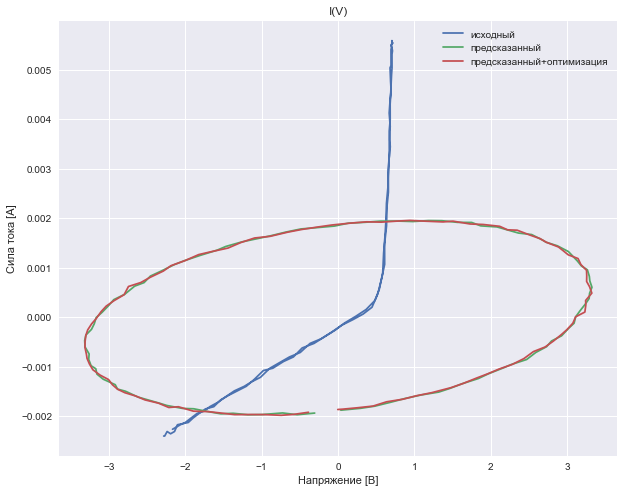

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


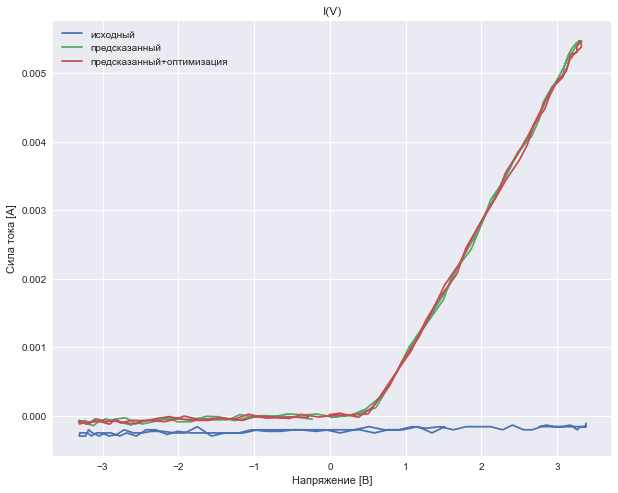

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


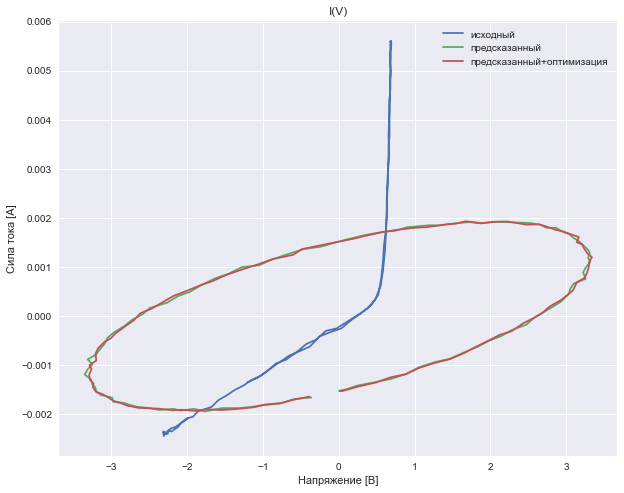

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


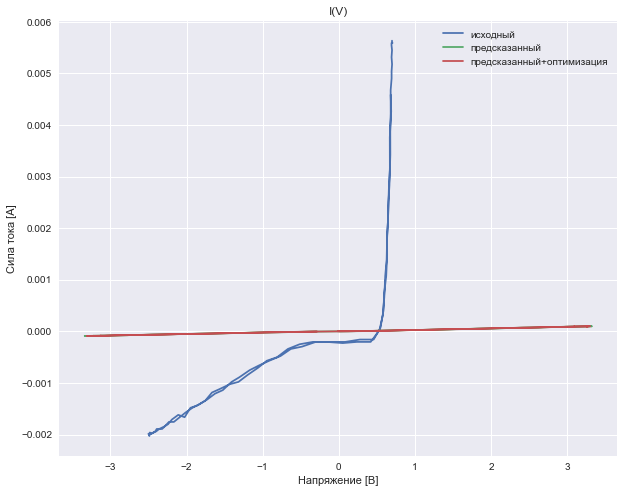

**file E:\EyePoint\RealSignalFolder\100hz_2020.json
F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


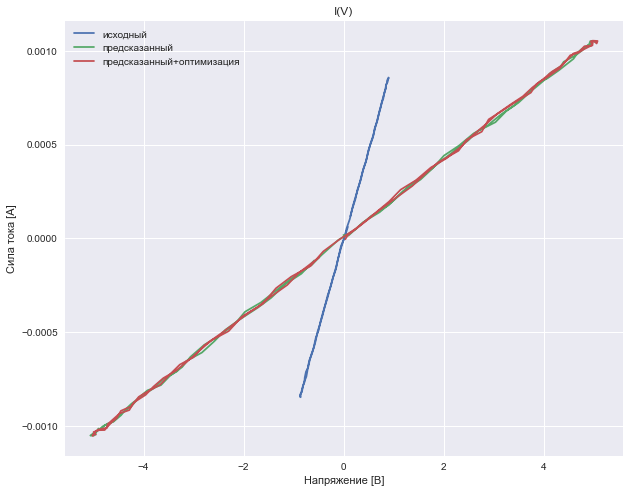

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


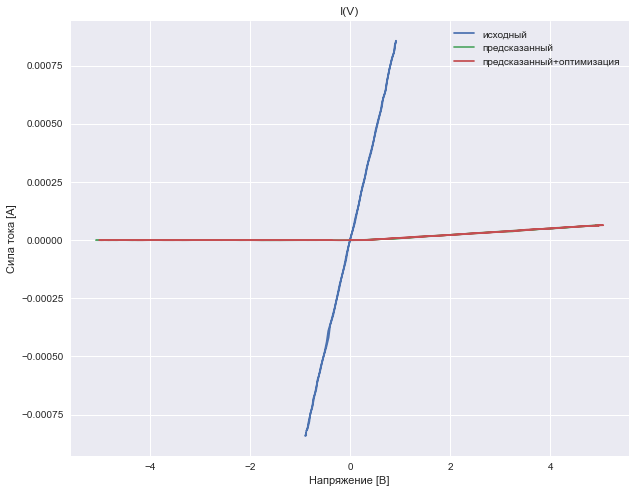

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


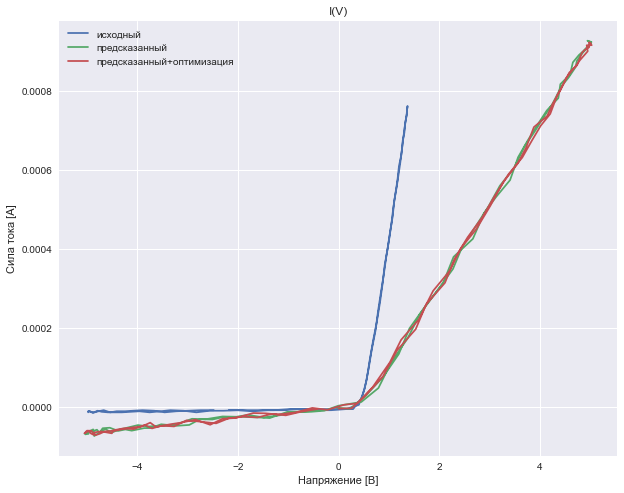

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


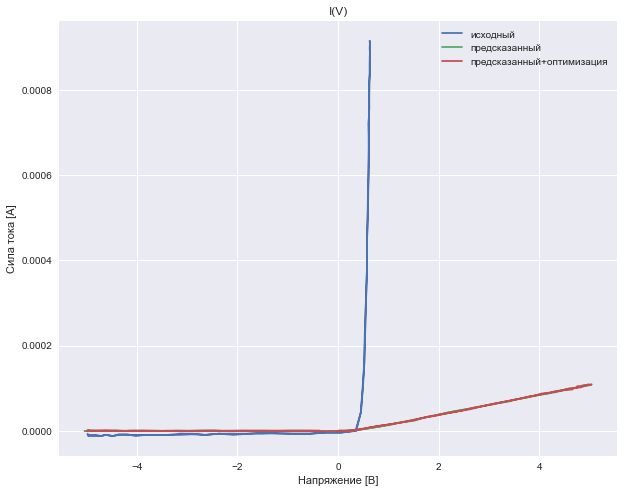

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


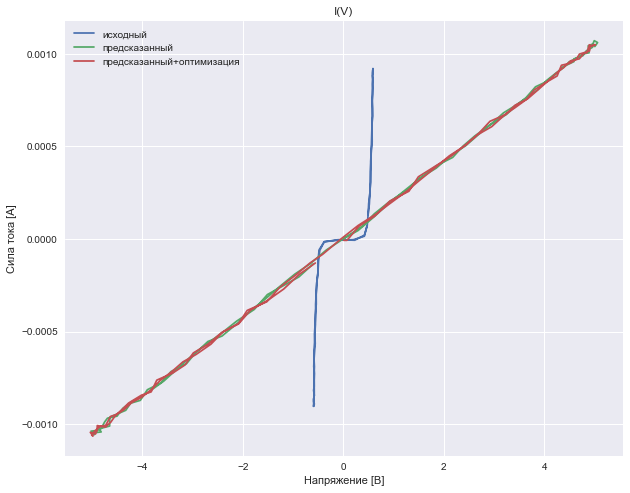

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


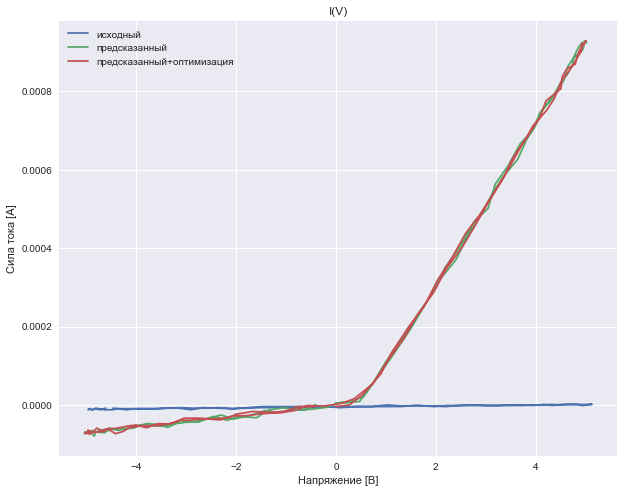

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


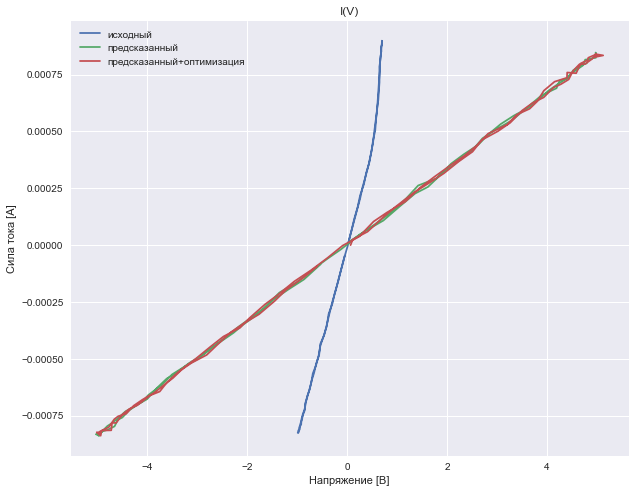

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


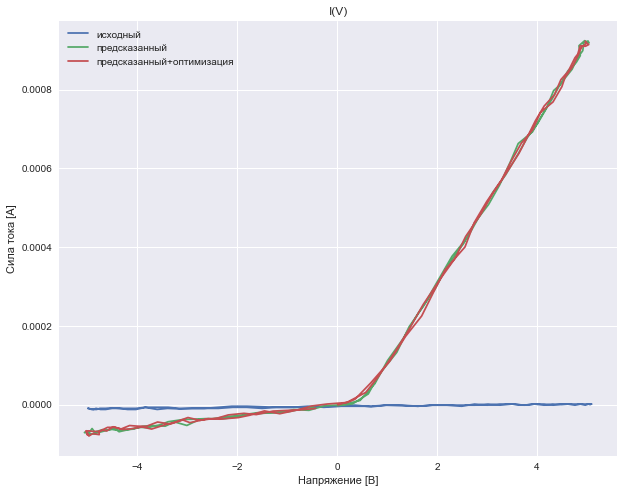

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


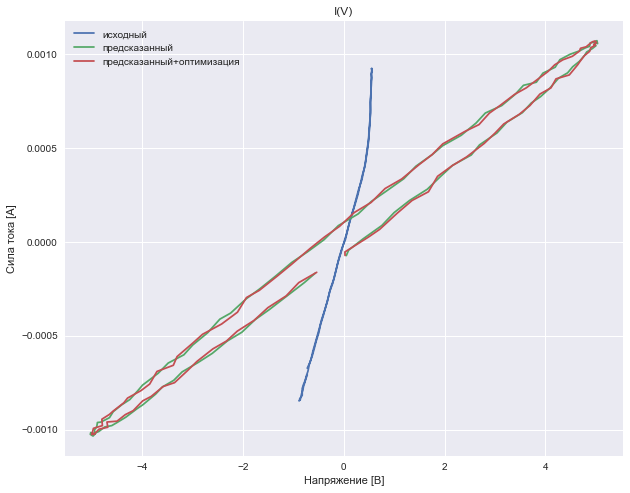

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


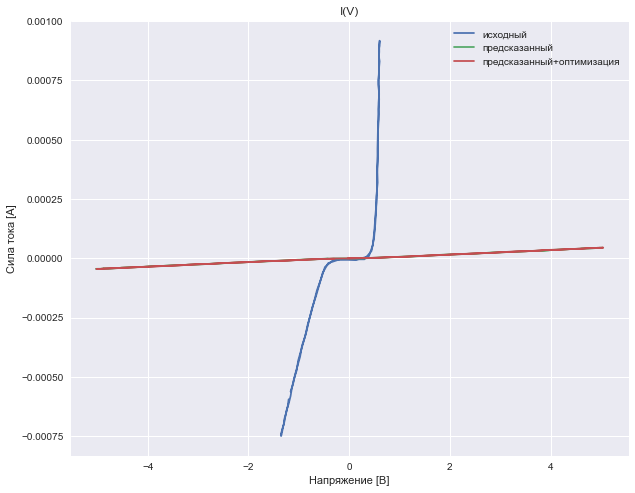

**file E:\EyePoint\RealSignalFolder\100khz_2020.json
F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


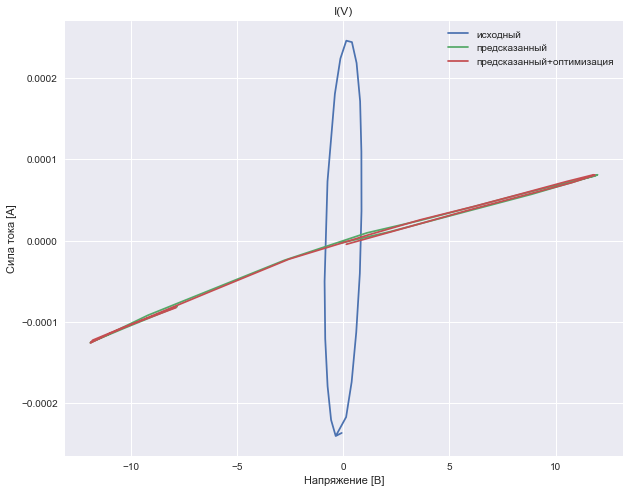

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


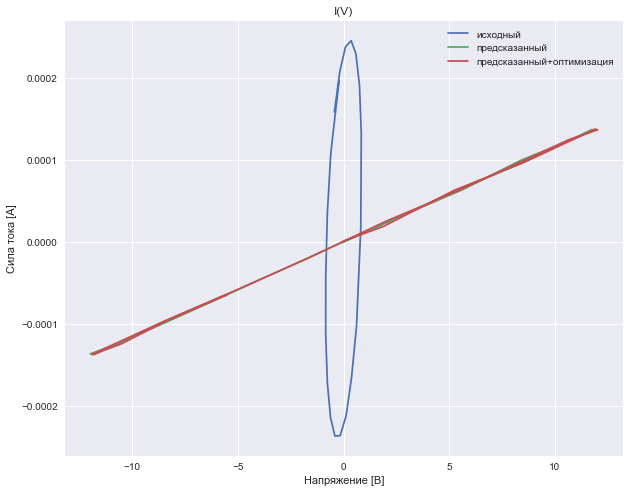

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


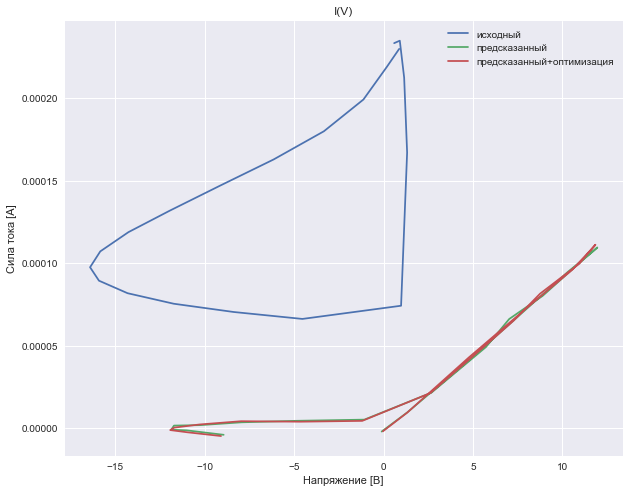

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


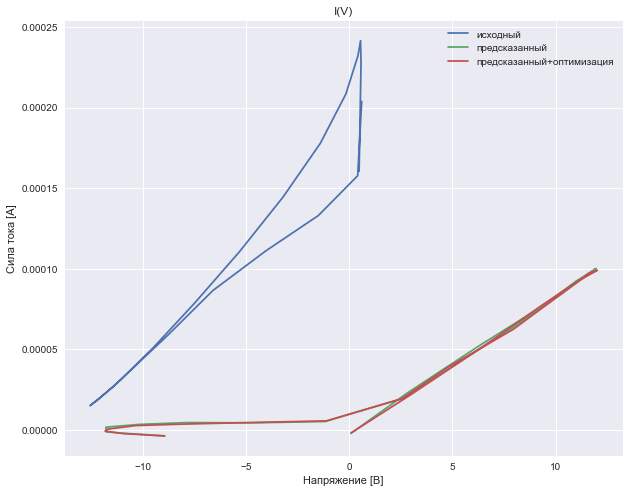

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


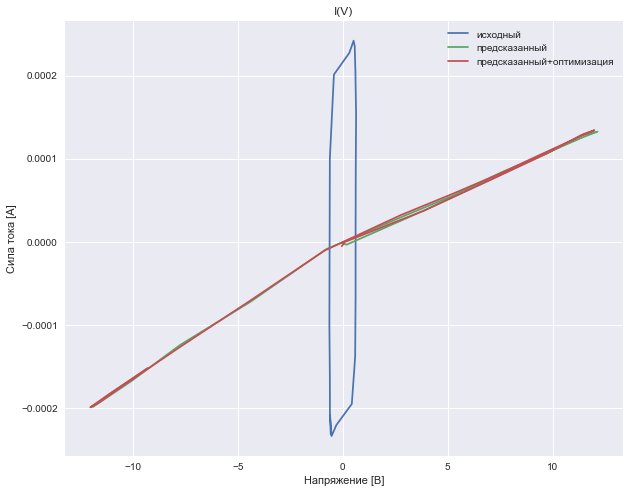

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


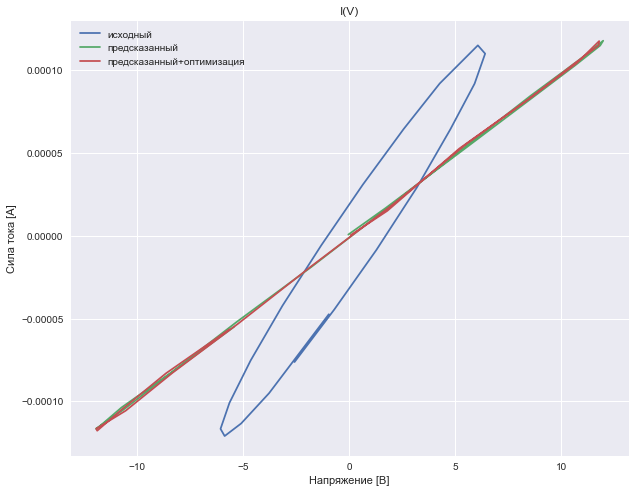

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


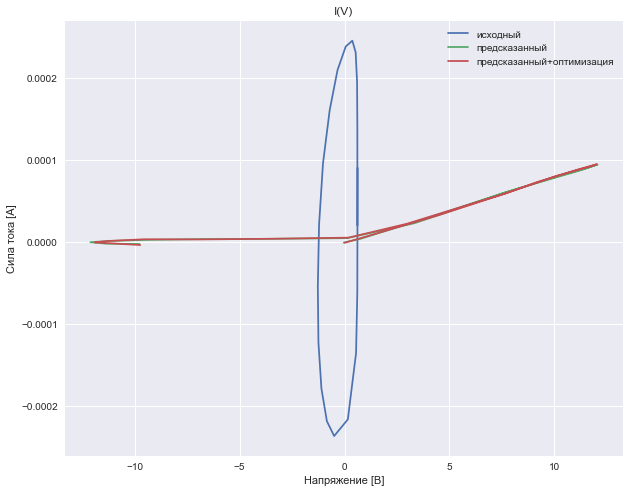

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


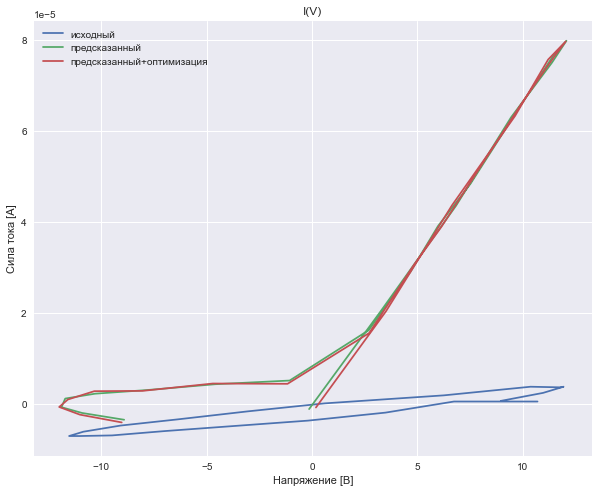

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


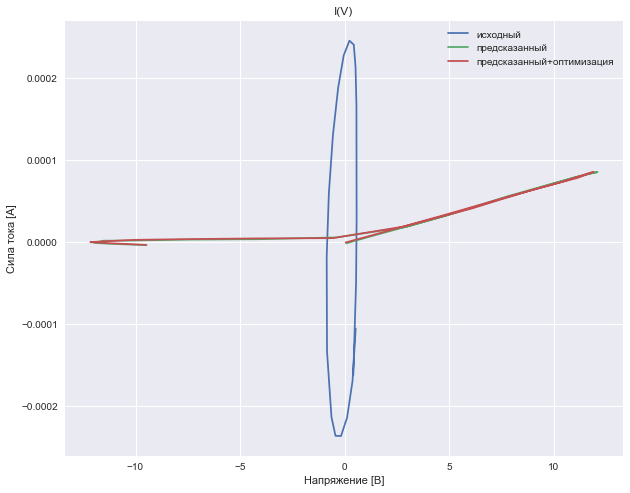

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


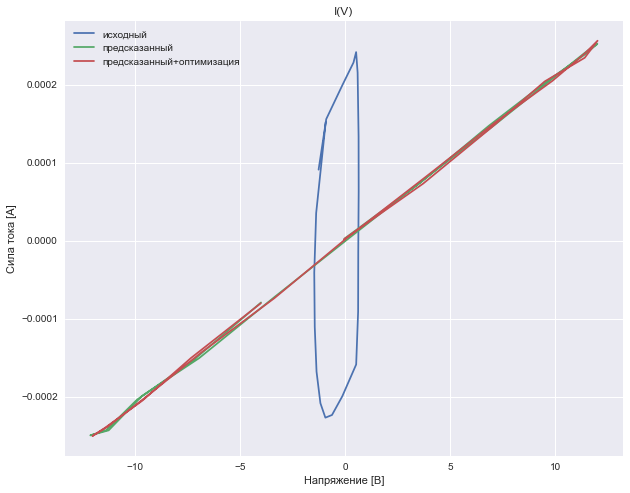

Wall time: 50.1 s


In [18]:
%%time
cre.test_all_json()